### Summary:
We've decided to revist these analyses for the first figure in the paper. We want to demonstrate the inherent variation already present in the dataset to lead into the phenotype comparison analyses. Testing for relationships between cell proportion will fit in well, since we already show how the proportion of cell types varies a lot.

In [1]:
# suppressMessages(library(hdf5r))
# suppressMessages(library(Seurat))
# suppressMessages(library(Signac))

suppressMessages(library(dplyr))
suppressMessages(library(stringr))
suppressMessages(library(tictoc))

suppressMessages(library(ggplot2))
suppressMessages(library(ggpubr))
# suppressMessages(library(ggfittext))
suppressMessages(library(RColorBrewer))

# Set up

In [2]:
prev_outdir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/230418_celltype_prop_assocs'
#outdir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240112_celltype_prop_assocs_v2'
outdir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/proportions'

In [3]:
#celltypes <- unique(adata@meta.data$major_celltypes_fin)
celltypes <- c('beta', 'alpha', 'delta', 'gamma', 'acinar',
               'ductal', 'endothelial', 'immune', 'stellate')

samples <- c('R207','R217','R218','R221','R223',
             'R226','R228','R234','R237','R238',
             'R246', 'R247', 'R275', 'R284', 
             'R290', 'R292', 'R316', 'R317', 'R319',
             'R325','R326','R327','R332',
             'R353','R354','R362','R363','R364')
length(samples)

[1] 28

In [4]:
major_colors = c('acinar'='#09850B', 'alpha'='#F51646', 'beta'='#3F98E0',
                 'delta'='#E39E14', 'ductal'='#F5DE6C', 'endothelial'='#752BBA', 
                 'gamma'='#A1D99B', 'immune'='#F598C9', 
                 'schwann'='#A84E03', 'stellate'='#FDBB84')

# Recalculate cell type proportions per sample
- Both overall and per compartment

In [ ]:
# Read in the final Seurat object
indir <- "/nfs/lab/hmummey/multiomic_islet/intermediates/220720_multiome_clustering_redo"
rds_fp <- file.path(indir,"221125_28sample_combined.noDoublets.QCfilters.ATAC_peaks.FINAL_v2.w_mergedPeaks_SM.rds")
tic()
adata <- readRDS(rds_fp)
toc()

#reclassify schwann cells as stellate (should do permanently at some point)
major_celltypes_fin <- adata@meta.data$major_celltypes
major_celltypes_fin[major_celltypes_fin == "schwann"] <- "stellate"
adata$major_celltypes_fin <- major_celltypes_fin
adata

### Overall proportions

In [67]:
# Calculate proportion of each celltype across samples
ct_counts <- list()

for (sample in samples){
    sample_matrix <- adata@meta.data[adata$library == sample,]
    counts <- c()
    for (celltype in celltypes){
        ct_sample_matrix <- sample_matrix[sample_matrix$major_celltypes_fin == celltype,]
        counts_ct <- sum(ct_sample_matrix$nCount_RNA)
        sum_cells <- dim(sample_matrix[sample_matrix$major_celltypes_fin == celltype,])[1]
        counts <- c(counts, 10000/sum_cells * counts_ct)
    }
    ct_counts[[sample]] <- counts
}

counts_df <- as.data.frame(t(as.data.frame(ct_counts)))
colnames(counts_df) <- celltypes
head(counts_df)

beta     alpha    delta    gamma    acinar   ductal   endothelial immune  
R207 54150106 44785015 49619787 39419815 28087860 37650880 22815177    18849239
R217 63011872 48771037 51974058 50709552 40808763 42928964 36235785    28022195
R218 38707298 33316265 33703576 21955631 19217096 22505115 27240722    12942187
R221 40386319 42207989 40687157 29740632 22172055 31784137 27377969    30178902
R223 62223609 49013850 48683268 44268825 27459925 38472081 29129196    31838613
R226 77187060 60283346 71653274 60178532 32173361 52497462 22468336    58971651
     stellate
R207 24198352
R217 35973500
R218 30352068
R221 24366944
R223 38349820
R226 37423860

In [68]:
# scale counts
counts_df_scaled <- -log10(counts_df)
colnames(counts_df_scaled) <- paste0(colnames(counts_df), '_scaled_counts')
props <- counts_df_scaled

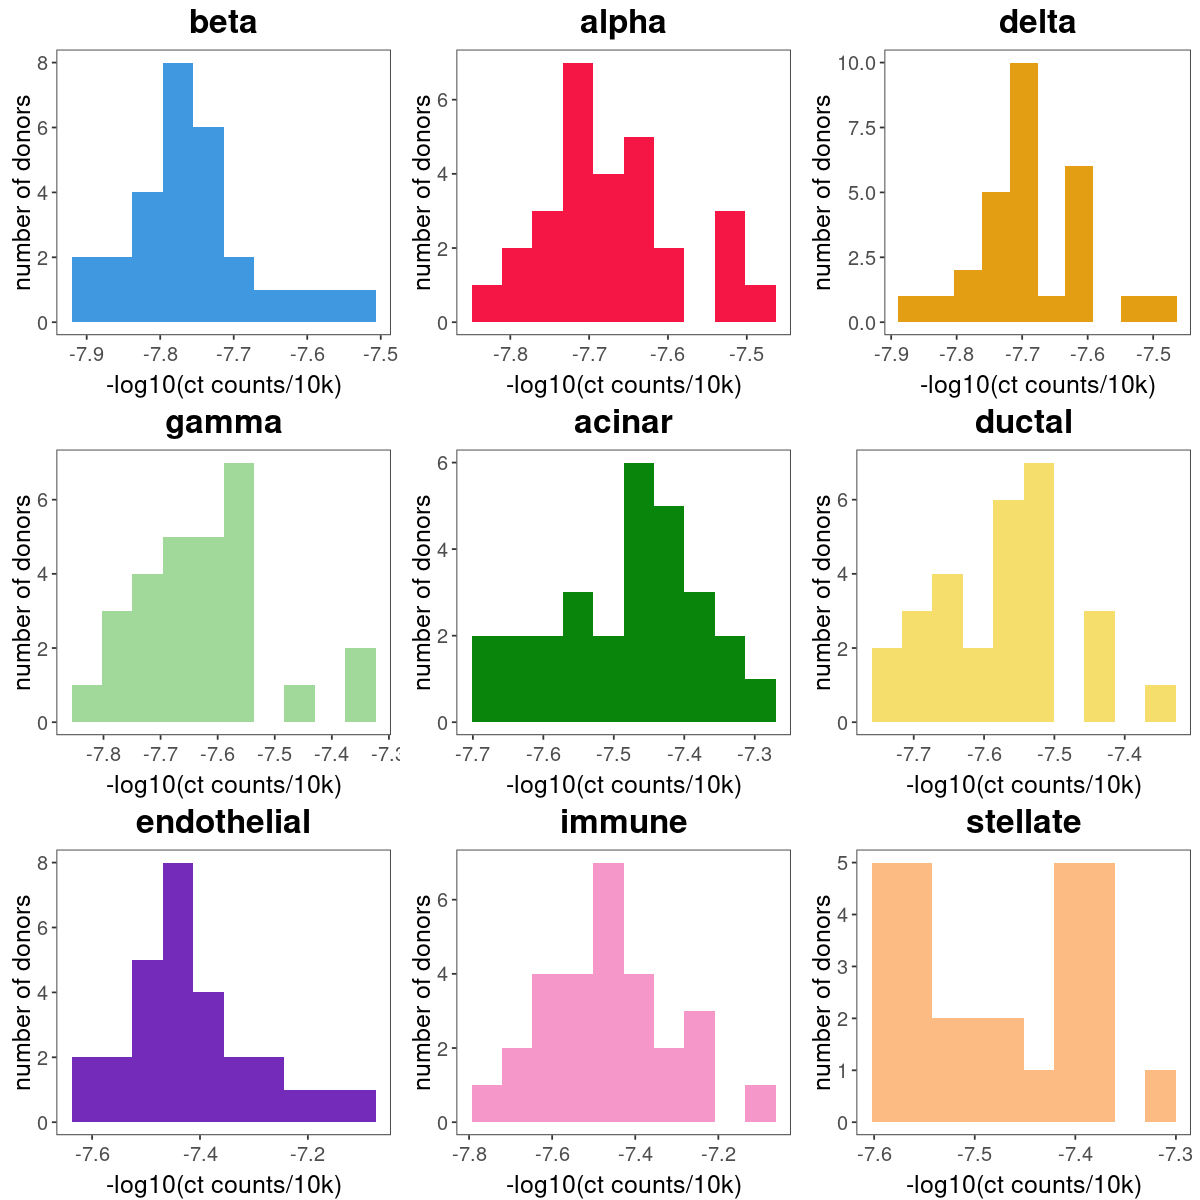

In [69]:
plots <- list()   
theme_set(theme_bw())

for (celltype in celltypes){
    data <- as.data.frame(props[,paste0(celltype,'_scaled_counts')])
    colnames(data) <- c('counts') 
    p1 <- ggplot(data, aes(x=counts)) + 
            geom_histogram(bins=10, fill=major_colors[[celltype]]) + 
            labs(x = '-log10(ct counts/10k)', y='number of donors', title = celltype) + 
            theme(axis.text.x=element_text(size=12, vjust=0.5),
                axis.text.y=element_text(size=12, vjust=0.5),
                axis.title.x = element_text(size=15, vjust=-0.35),
                axis.title.y = element_text(size=15, vjust=0.5),
                plot.title = element_text(size=20, hjust=0.5, face="bold"),
                panel.grid.major = element_blank(), panel.grid.minor = element_blank())
    plots[[celltype]] <- p1
}

options(repr.plot.width=10, repr.plot.height=10)
ggarrange(plotlist=plots, nrow = 3, ncol=3)

In [30]:
#write to file
counts_fp <- file.path(outdir, 'Alberta_celltype_counts_per10k.txt')
write.table(props, counts_fp, sep='\t', quote=FALSE)

### Proportions per compartment

In [62]:
endo_celltypes <- c('beta','alpha','delta','gamma')
nonendo_celltypes <- c('acinar','ductal','endothelial','immune','stellate')

In [63]:
# Calculate proportion of each celltype across samples -- within compartment
ct_counts2 <- list()

for (sample in samples){
    sample_matrix <- adata@meta.data[adata$library == sample,]
    props2 <- c()
    for (celltype in endo_celltypes){
        prop_ct <- sum(sample_matrix$major_celltypes_fin == celltype)/sum(sample_matrix$major_celltypes_fin %in% endo_celltypes)
        props2 <- c(props2, prop_ct)
    }
    for (celltype in nonendo_celltypes){
        prop_ct <- sum(sample_matrix$major_celltypes_fin == celltype)/sum(sample_matrix$major_celltypes_fin %in% nonendo_celltypes)
        props2 <- c(props2, prop_ct)        
    }
    ct_counts2[[sample]] <- props2
}

# Reformat results and add onto meta df
comp_props_df <- data.frame(t(as.data.frame(ct_counts2)))
colnames(comp_props_df) <- paste(celltypes, '_comp_prop',sep='')
head(comp_props_df)

beta_comp_prop alpha_comp_prop delta_comp_prop gamma_comp_prop
R207 0.5797127      0.3635548       0.03895871      0.01777379     
R217 0.5728583      0.1393114       0.06004804      0.22778223     
R218 0.7715317      0.1170707       0.06859206      0.04280557     
R221 0.4828689      0.4134308       0.08359982      0.02010050     
R223 0.6400371      0.2995366       0.04170528      0.01872104     
R226 0.6476229      0.2980423       0.03855374      0.01578106     
     acinar_comp_prop ductal_comp_prop endothelial_comp_prop immune_comp_prop
R207 0.8554572        0.06637168       0.0117994100          0.048672566     
R217 0.7975008        0.19673182       0.0006408202          0.003204101     
R218 0.7081545        0.22317597       0.0085836910          0.017167382     
R221 0.8805750        0.10836712       0.0029487652          0.001842978     
R223 0.7500000        0.21413502       0.0073839662          0.008438819     
R226 0.9443801        0.03939745       0.0023174971          0.004634994     
     stellate_comp_prop
R207 0.017699115       
R217 0.001922461       
R218 0.042918455       
R221 0.006266126       
R223 0.020042194       
R226 0.009269988

In [64]:
# scale counts
comp_props_df_scaled <- sqrt(comp_props_df)
colnames(comp_props_df_scaled) <- paste0(colnames(comp_props_df), '_sqrt')
props2 <- cbind(comp_props_df,comp_props_df_scaled)
head(props2)

beta_comp_prop alpha_comp_prop delta_comp_prop gamma_comp_prop
R207 0.5797127      0.3635548       0.03895871      0.01777379     
R217 0.5728583      0.1393114       0.06004804      0.22778223     
R218 0.7715317      0.1170707       0.06859206      0.04280557     
R221 0.4828689      0.4134308       0.08359982      0.02010050     
R223 0.6400371      0.2995366       0.04170528      0.01872104     
R226 0.6476229      0.2980423       0.03855374      0.01578106     
     acinar_comp_prop ductal_comp_prop endothelial_comp_prop immune_comp_prop
R207 0.8554572        0.06637168       0.0117994100          0.048672566     
R217 0.7975008        0.19673182       0.0006408202          0.003204101     
R218 0.7081545        0.22317597       0.0085836910          0.017167382     
R221 0.8805750        0.10836712       0.0029487652          0.001842978     
R223 0.7500000        0.21413502       0.0073839662          0.008438819     
R226 0.9443801        0.03939745       0.0023174971          0.004634994     
     stellate_comp_prop beta_comp_prop_sqrt alpha_comp_prop_sqrt
R207 0.017699115        0.7613887           0.6029550           
R217 0.001922461        0.7568740           0.3732445           
R218 0.042918455        0.8783688           0.3421559           
R221 0.006266126        0.6948877           0.6429858           
R223 0.020042194        0.8000232           0.5472994           
R226 0.009269988        0.8047502           0.5459326           
     delta_comp_prop_sqrt gamma_comp_prop_sqrt acinar_comp_prop_sqrt
R207 0.1973796            0.1333184            0.9249093            
R217 0.2450470            0.4772654            0.8930290            
R218 0.2619009            0.2068951            0.8415192            
R221 0.2891363            0.1417762            0.9383896            
R223 0.2042187            0.1368248            0.8660254            
R226 0.1963511            0.1256227            0.9717922            
     ductal_comp_prop_sqrt endothelial_comp_prop_sqrt immune_comp_prop_sqrt
R207 0.2576270             0.10862509                 0.22061860           
R217 0.4435446             0.02531443                 0.05660478           
R218 0.4724150             0.09264821                 0.13102436           
R221 0.3291916             0.05430253                 0.04292992           
R223 0.4627473             0.08593001                 0.09186304           
R226 0.1984879             0.04814039                 0.06808079           
     stellate_comp_prop_sqrt
R207 0.13303802             
R217 0.04384587             
R218 0.20716770             
R221 0.07915887             
R223 0.14157046             
R226 0.09628078

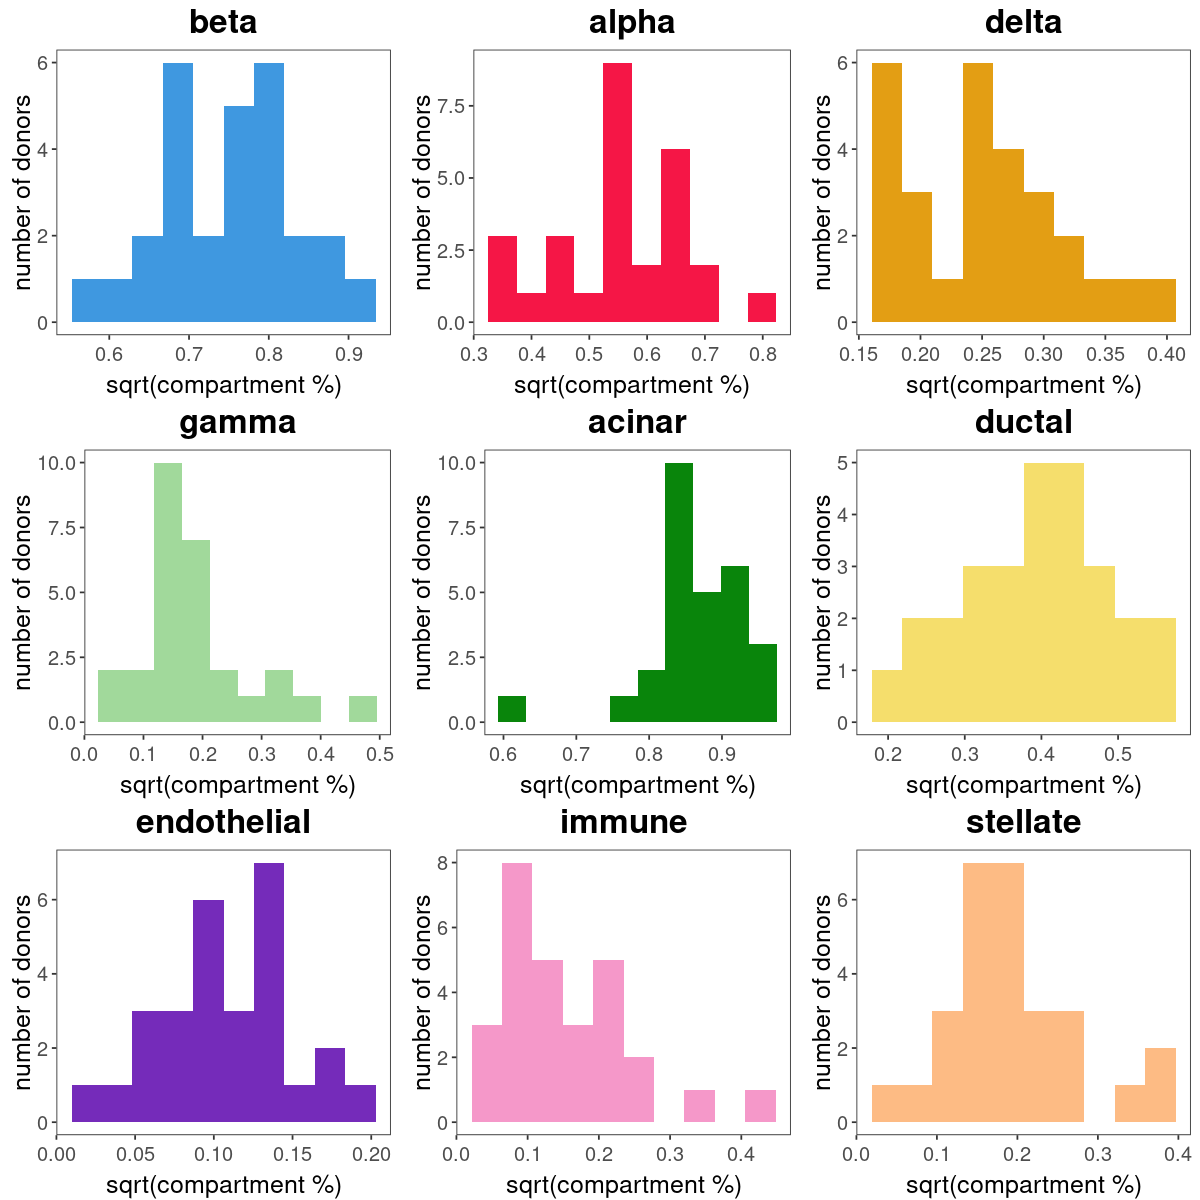

In [66]:
plots <- list()   
theme_set(theme_bw())

for (celltype in celltypes){
    data <- as.data.frame(props2[,paste0(celltype,'_comp_prop_sqrt')])
    colnames(data) <- c('counts') 
    p1 <- ggplot(data, aes(x=counts)) + 
            geom_histogram(bins=10, fill=major_colors[[celltype]]) + 
            labs(x = 'sqrt(compartment %)', y='number of donors', title = celltype) + 
            theme(axis.text.x=element_text(size=12, vjust=0.5),
                axis.text.y=element_text(size=12, vjust=0.5),
                axis.title.x = element_text(size=15, vjust=-0.35),
                axis.title.y = element_text(size=15, vjust=0.5),
                plot.title = element_text(size=20, hjust=0.5, face="bold"),
                panel.grid.major = element_blank(), panel.grid.minor = element_blank())
    plots[[celltype]] <- p1
}

options(repr.plot.width=10, repr.plot.height=10)
ggarrange(plotlist=plots, nrow = 3, ncol=3)

In [26]:
# Write to file
prop_fp <- file.path(outdir, 'Alberta_celltype_compartment_prop_wsqrt.txt')
write.table(props2, prop_fp, sep='\t', quote=FALSE)

### Total proportions (per all donor cells)

In [213]:
# Calculate proportion of each celltype across samples -- within compartment
ct_counts3 <- list()

for (sample in samples){
    sample_matrix <- adata@meta.data[adata$library == sample,]
    props3 <- c()
    for (celltype in celltypes){
        prop_ct <- sum(sample_matrix$major_celltypes_fin == celltype)/dim(sample_matrix)[1]
        props3 <- c(props3, prop_ct)
    }
    ct_counts3[[sample]] <- props3
}

# Reformat results and add onto meta df
comp_props_df <- data.frame(t(as.data.frame(ct_counts3)))
colnames(comp_props_df) <- paste(celltypes, '_total_prop',sep='')
head(comp_props_df)

beta_total_prop alpha_total_prop delta_total_prop gamma_total_prop
R207 0.5168054       0.32410371       0.03473111       0.015845070     
R217 0.2546716       0.06193273       0.02669514       0.101263570     
R218 0.6887661       0.10451197       0.06123389       0.038213628     
R221 0.2156263       0.18461852       0.03733170       0.008975928     
R223 0.5443796       0.25476904       0.03547217       0.015923065     
R226 0.5523939       0.25421707       0.03288465       0.013460555     
     acinar_total_prop ductal_total_prop endothelial_total_prop
R207 0.09282971        0.007202305       0.0012804097          
R217 0.44296138        0.109272112       0.0003559352          
R218 0.07596685        0.023941068       0.0009208103          
R221 0.48735210        0.059975520       0.0016319869          
R223 0.11209207        0.032003784       0.0011035787          
R226 0.13886522        0.005793150       0.0003407736          
     immune_total_prop stellate_total_prop
R207 0.0052816901      0.001920615        
R217 0.0017796761      0.001067806        
R218 0.0018416206      0.004604052        
R221 0.0010199918      0.003467972        
R223 0.0012612329      0.002995428        
R226 0.0006815471      0.001363094

In [214]:
# scale counts
comp_props_df_scaled <- sqrt(comp_props_df)
colnames(comp_props_df_scaled) <- paste0(colnames(comp_props_df), '_sqrt')
props3 <- cbind(comp_props_df,comp_props_df_scaled)
head(props3)

beta_total_prop alpha_total_prop delta_total_prop gamma_total_prop
R207 0.5168054       0.32410371       0.03473111       0.015845070     
R217 0.2546716       0.06193273       0.02669514       0.101263570     
R218 0.6887661       0.10451197       0.06123389       0.038213628     
R221 0.2156263       0.18461852       0.03733170       0.008975928     
R223 0.5443796       0.25476904       0.03547217       0.015923065     
R226 0.5523939       0.25421707       0.03288465       0.013460555     
     acinar_total_prop ductal_total_prop endothelial_total_prop
R207 0.09282971        0.007202305       0.0012804097          
R217 0.44296138        0.109272112       0.0003559352          
R218 0.07596685        0.023941068       0.0009208103          
R221 0.48735210        0.059975520       0.0016319869          
R223 0.11209207        0.032003784       0.0011035787          
R226 0.13886522        0.005793150       0.0003407736          
     immune_total_prop stellate_total_prop beta_total_prop_sqrt
R207 0.0052816901      0.001920615         0.7188918           
R217 0.0017796761      0.001067806         0.5046500           
R218 0.0018416206      0.004604052         0.8299193           
R221 0.0010199918      0.003467972         0.4643558           
R223 0.0012612329      0.002995428         0.7378209           
R226 0.0006815471      0.001363094         0.7432321           
     alpha_total_prop_sqrt delta_total_prop_sqrt gamma_total_prop_sqrt
R207 0.5693011             0.1863629             0.12587720           
R217 0.2488629             0.1633865             0.31821937           
R218 0.3232831             0.2474548             0.19548306           
R221 0.4296726             0.1932141             0.09474138           
R223 0.5047465             0.1883406             0.12618663           
R226 0.5041994             0.1813412             0.11601963           
     acinar_total_prop_sqrt ductal_total_prop_sqrt endothelial_total_prop_sqrt
R207 0.3046797              0.08486639             0.03578281                 
R217 0.6655534              0.33056333             0.01886625                 
R218 0.2756208              0.15472902             0.03034486                 
R221 0.6981061              0.24489900             0.04039786                 
R223 0.3348015              0.17889601             0.03322016                 
R226 0.3726462              0.07611275             0.01846005                 
     immune_total_prop_sqrt stellate_total_prop_sqrt
R207 0.07267524             0.04382482              
R217 0.04218621             0.03267730              
R218 0.04291411             0.06785316              
R221 0.03193731             0.05888949              
R223 0.03551384             0.05473050              
R226 0.02610646             0.03692011

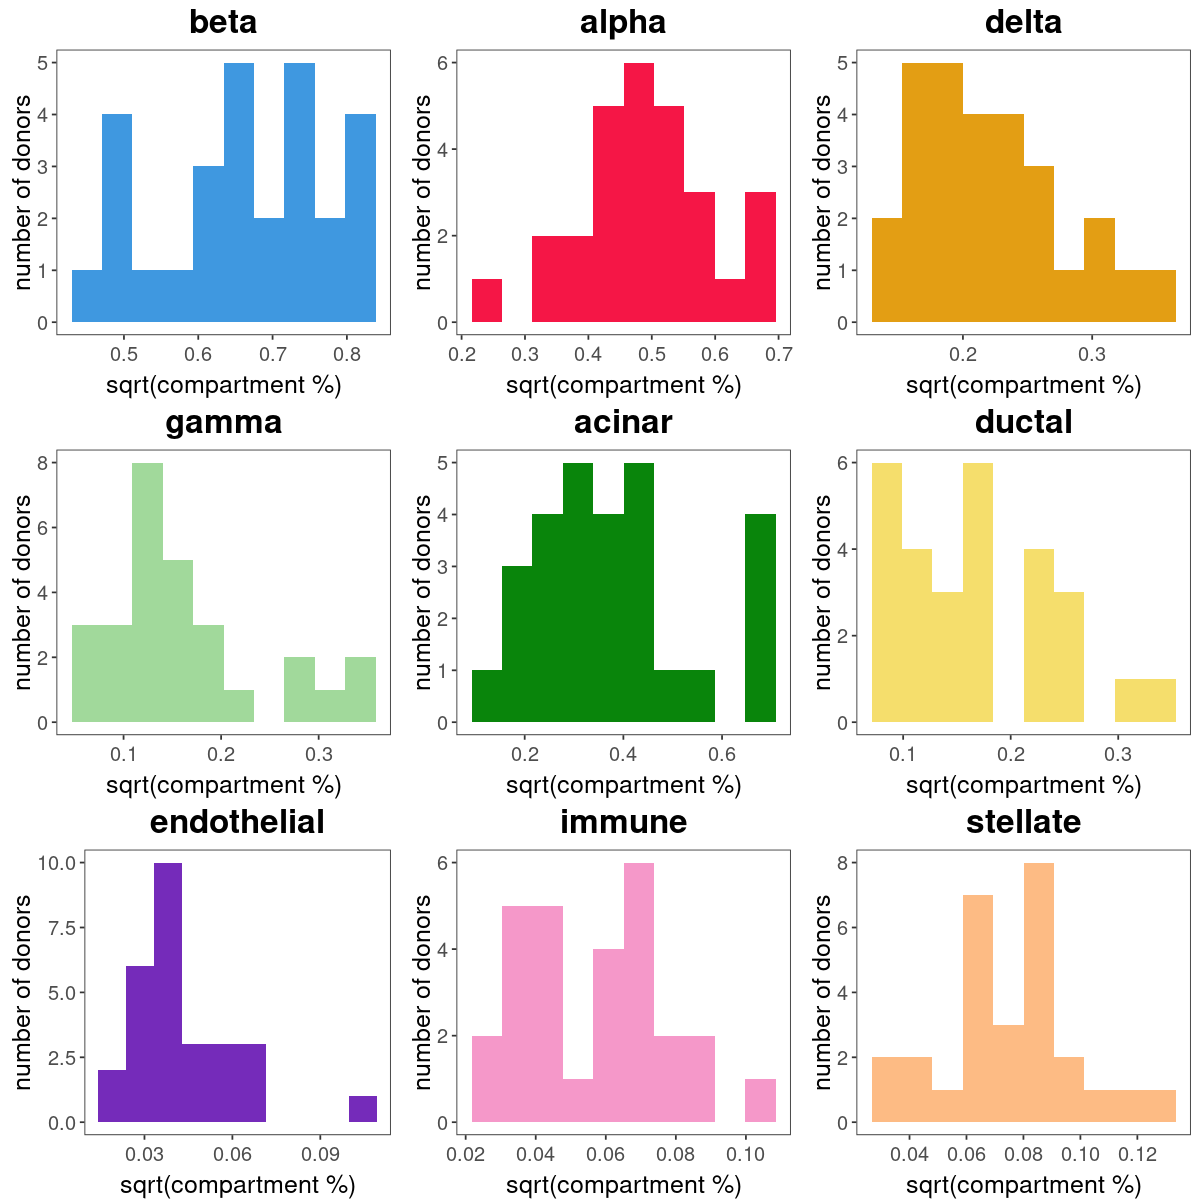

In [216]:
plots <- list()   
theme_set(theme_bw())

for (celltype in celltypes){
    data <- as.data.frame(props3[,paste0(celltype,'_total_prop_sqrt')])
    colnames(data) <- c('counts') 
    p1 <- ggplot(data, aes(x=counts)) + 
            geom_histogram(bins=10, fill=major_colors[[celltype]]) + 
            labs(x = 'sqrt(compartment %)', y='number of donors', title = celltype) + 
            theme(axis.text.x=element_text(size=12, vjust=0.5),
                axis.text.y=element_text(size=12, vjust=0.5),
                axis.title.x = element_text(size=15, vjust=-0.35),
                axis.title.y = element_text(size=15, vjust=0.5),
                plot.title = element_text(size=20, hjust=0.5, face="bold"),
                panel.grid.major = element_blank(), panel.grid.minor = element_blank())
    plots[[celltype]] <- p1
}

options(repr.plot.width=10, repr.plot.height=10)
ggarrange(plotlist=plots, nrow = 3, ncol=3)

In [217]:
# Write to file
prop_fp <- file.path(outdir, 'Alberta_celltype_total_prop_wsqrt.txt')
write.table(props2, prop_fp, sep='\t', quote=FALSE)

# Overall proportion tests

## Read inputs for associations

### Read in cell type proportions per sample

In [5]:
#read in either 10k scaled counts or sqrt compartment proportion 
prop_fp <- file.path(outdir, 'props_tables', 'Alberta_celltype_total_prop_wsqrt.txt')
df <- read.table(prop_fp, sep='\t')
head(df)
colnames(df)

beta_total_prop alpha_total_prop delta_total_prop gamma_total_prop
R207 0.5168054       0.32410371       0.03473111       0.015845070     
R217 0.2546716       0.06193273       0.02669514       0.101263570     
R218 0.6887661       0.10451197       0.06123389       0.038213628     
R221 0.2156263       0.18461852       0.03733170       0.008975928     
R223 0.5443796       0.25476904       0.03547217       0.015923065     
R226 0.5523939       0.25421707       0.03288465       0.013460555     
     acinar_total_prop ductal_total_prop endothelial_total_prop
R207 0.09282971        0.007202305       0.0012804097          
R217 0.44296138        0.109272112       0.0003559352          
R218 0.07596685        0.023941068       0.0009208103          
R221 0.48735210        0.059975520       0.0016319869          
R223 0.11209207        0.032003784       0.0011035787          
R226 0.13886522        0.005793150       0.0003407736          
     immune_total_prop stellate_total_prop beta_total_prop_sqrt
R207 0.0052816901      0.001920615         0.7188918           
R217 0.0017796761      0.001067806         0.5046500           
R218 0.0018416206      0.004604052         0.8299193           
R221 0.0010199918      0.003467972         0.4643558           
R223 0.0012612329      0.002995428         0.7378209           
R226 0.0006815471      0.001363094         0.7432321           
     alpha_total_prop_sqrt delta_total_prop_sqrt gamma_total_prop_sqrt
R207 0.5693011             0.1863629             0.12587720           
R217 0.2488629             0.1633865             0.31821937           
R218 0.3232831             0.2474548             0.19548306           
R221 0.4296726             0.1932141             0.09474138           
R223 0.5047465             0.1883406             0.12618663           
R226 0.5041994             0.1813412             0.11601963           
     acinar_total_prop_sqrt ductal_total_prop_sqrt endothelial_total_prop_sqrt
R207 0.3046797              0.08486639             0.03578281                 
R217 0.6655534              0.33056333             0.01886625                 
R218 0.2756208              0.15472902             0.03034486                 
R221 0.6981061              0.24489900             0.04039786                 
R223 0.3348015              0.17889601             0.03322016                 
R226 0.3726462              0.07611275             0.01846005                 
     immune_total_prop_sqrt stellate_total_prop_sqrt
R207 0.07267524             0.04382482              
R217 0.04218621             0.03267730              
R218 0.04291411             0.06785316              
R221 0.03193731             0.05888949              
R223 0.03551384             0.05473050              
R226 0.02610646             0.03692011

[1] "beta_total_prop"             "alpha_total_prop"           
 [3] "delta_total_prop"            "gamma_total_prop"           
 [5] "acinar_total_prop"           "ductal_total_prop"          
 [7] "endothelial_total_prop"      "immune_total_prop"          
 [9] "stellate_total_prop"         "beta_total_prop_sqrt"       
[11] "alpha_total_prop_sqrt"       "delta_total_prop_sqrt"      
[13] "gamma_total_prop_sqrt"       "acinar_total_prop_sqrt"     
[15] "ductal_total_prop_sqrt"      "endothelial_total_prop_sqrt"
[17] "immune_total_prop_sqrt"      "stellate_total_prop_sqrt"

In [6]:
# prep list of cell type prop values to test -- adjust based on input data
ct_props <- paste(celltypes, 'total_prop_sqrt', sep='_')
ct_props
table(ct_props %in% colnames(df))

[1] "beta_total_prop_sqrt"        "alpha_total_prop_sqrt"      
[3] "delta_total_prop_sqrt"       "gamma_total_prop_sqrt"      
[5] "acinar_total_prop_sqrt"      "ductal_total_prop_sqrt"     
[7] "endothelial_total_prop_sqrt" "immune_total_prop_sqrt"     
[9] "stellate_total_prop_sqrt"


TRUE 
   9 

### Read in detailed donor metadata

In [7]:
# Read in expanded metadata table
meta_dir <- '/nfs/lab/projects/multiomic_islet/data/sample_metadata'
meta_fp <- file.path(meta_dir, '240110_donor_metadata_combined_clean.tsv')
meta <- read.table(meta_fp, sep='\t')

#cut down to columns of interest and rename some
meta <- meta %>% select(age, body_mass_index, glycated_hemoglobin, sex, culture_time, cold_ischemia_time, 
                        pancreas_weight, purity, pancreas_consistency, collagenase_type) %>%
        rename(BMI=body_mass_index, HbA1c=glycated_hemoglobin)

#scale all continuous variables
cont_vars <- colnames(meta)[c(1,2,3,5,6,7,8)]
for (col_name in cont_vars){
    new_name <- paste0('scaled_', col_name)
    meta[new_name] <- as.double(scale(meta[,col_name]))
    meta <- meta %>% relocate(all_of(new_name), .after=all_of(col_name))
}

dim(meta)
#head(meta)

[1] 28 17

In [8]:
#add in proportion df to meta so can just pass one df to functions
table(row.names(df) == row.names(meta))
meta_fin <- cbind(meta, df)
dim(meta_fin)
head(meta_fin)


TRUE 
  28 

[1] 28 35

age scaled_age BMI  scaled_BMI HbA1c scaled_HbA1c sex    culture_time
R207 50  -0.3176239 22.2 -1.5961071  NA           NA   Female  70         
R217 71   1.1885281 35.5  1.5372102 6.3    1.7566453   Female  15         
R218 73   1.3319711 28.4 -0.1354630 5.9    0.9320975   Female  70         
R221 44  -0.7479530 30.5  0.3592713 5.3   -0.3047242   Male   136         
R223 54  -0.0307378 27.0 -0.4652858 5.8    0.7259606   Male    64         
R226 30  -1.7520544 32.3  0.7833293 4.9   -1.1292720   Female  16         
     scaled_culture_time cold_ischemia_time ⋯ stellate_total_prop
R207  0.7433497          16.60              ⋯ 0.001920615        
R217 -0.9339522          35.00              ⋯ 0.001067806        
R218  0.7433497          17.00              ⋯ 0.004604052        
R221  2.7561120           6.25              ⋯ 0.003467972        
R223  0.5603713          14.00              ⋯ 0.002995428        
R226 -0.9034558          18.60              ⋯ 0.001363094        
     beta_total_prop_sqrt alpha_total_prop_sqrt delta_total_prop_sqrt
R207 0.7188918            0.5693011             0.1863629            
R217 0.5046500            0.2488629             0.1633865            
R218 0.8299193            0.3232831             0.2474548            
R221 0.4643558            0.4296726             0.1932141            
R223 0.7378209            0.5047465             0.1883406            
R226 0.7432321            0.5041994             0.1813412            
     gamma_total_prop_sqrt acinar_total_prop_sqrt ductal_total_prop_sqrt
R207 0.12587720            0.3046797              0.08486639            
R217 0.31821937            0.6655534              0.33056333            
R218 0.19548306            0.2756208              0.15472902            
R221 0.09474138            0.6981061              0.24489900            
R223 0.12618663            0.3348015              0.17889601            
R226 0.11601963            0.3726462              0.07611275            
     endothelial_total_prop_sqrt immune_total_prop_sqrt
R207 0.03578281                  0.07267524            
R217 0.01886625                  0.04218621            
R218 0.03034486                  0.04291411            
R221 0.04039786                  0.03193731            
R223 0.03322016                  0.03551384            
R226 0.01846005                  0.02610646            
     stellate_total_prop_sqrt
R207 0.04382482              
R217 0.03267730              
R218 0.06785316              
R221 0.05888949              
R223 0.05473050              
R226 0.03692011

## Quick test for outliers in meta data

In [9]:
# Extract data from one column in metadata
cont_vars <- c('scaled_age','scaled_BMI','scaled_HbA1c','scaled_culture_time',
               'scaled_cold_ischemia_time','scaled_pancreas_weight','scaled_purity')

for (colname in cont_vars){
    data <- meta[,colname]
    names(data) <- row.names(meta)
    data <- data[!is.na(data)]
    
    # Convert to z-scores
    zscores <- (data - mean(data))/sd(data)
    
    # Gather outlier samples
    sd_cutoff=3
    outliers <- names(zscores[abs(zscores) >= sd_cutoff])
    print(c(colname,outliers))
}

[1] "scaled_age"
[1] "scaled_BMI"
[1] "scaled_HbA1c"
[1] "scaled_culture_time"
[1] "scaled_cold_ischemia_time"
[1] "scaled_pancreas_weight"
[1] "scaled_purity" "R316"         


In [10]:
#also check which donor is fibrotic and remove that too?
subset(meta_fin,pancreas_consistency=='Fibrotic')

age scaled_age BMI  scaled_BMI  HbA1c scaled_HbA1c sex  culture_time
R275 46  -0.60451   28.7 -0.06478664 4.5   -1.95382     Male 18          
     scaled_culture_time cold_ischemia_time ⋯ stellate_total_prop
R275 -0.842463           13                 ⋯ 0.006413994        
     beta_total_prop_sqrt alpha_total_prop_sqrt delta_total_prop_sqrt
R275 0.7165271            0.4008009             0.2991728            
     gamma_total_prop_sqrt acinar_total_prop_sqrt ductal_total_prop_sqrt
R275 0.1637747             0.37835                0.2309822             
     endothelial_total_prop_sqrt immune_total_prop_sqrt
R275 0.06156369                  0.05399492            
     stellate_total_prop_sqrt
R275 0.08008742

In [11]:
#remove one outlier sample from data for all analyses (unideal but easiest bc included in all eqs)
meta_fin <- meta_fin[row.names(meta_fin) != 'R316',]
meta_fin <- meta_fin[row.names(meta_fin) != 'R275',]
dim(meta_fin)

[1] 26 35

## Run tests for relationships between cell type proportion and metadata

### Continuous covariates: glm based test

In [12]:
### Function to run a glm model for a ct_prop vs one var, including other vars as covars
run_ct_prop_glm <- function(meta, ct_prop, var, other_vars){
    #then fit glm and return info
    my_design <- as.formula(paste0(sprintf('%s ~ %s',ct_prop, var),paste0(rep(' + ',length(other_vars)), other_vars,collapse='')))
    print(my_design)
    fit <- glm(my_design, data=meta)
    return(fit)
}


### Wrapper function which will apply the glm model to all combinations of meta traits and cell prop traits
glm_wrapper <- function(meta, trait_list, ct_prop_list, run_prefix, outdir){
    # Create results df with filler columns (to set the row length)
    results <- data.frame(filler1=rep(0, length(trait_list)), filler2=rep(1, length(trait_list)))
    
    # For each cell type, make glms by each trait in trait_list, using remaining traits as covars
    for (ct_prop in ct_prop_list){
        ct <- unlist(str_split(ct_prop, '_'))[1]
        test_results <- run_ct_prop_glm(meta, ct_prop, trait_list[1], trait_list[-1])
        test_results_df <- coef(summary(test_results))
        test_results_cut <- test_results_df[-1,c(1,3,4)]
        results <- cbind(results, test_results_cut)
        
    }
    # Finalize results formatting
    results <- results[,-c(1,2)] #remove filler columns
    row.names(results) <- trait_list
    colnames(results) <- c(t(outer(ct_prop_list, c('coef', 'tvalue', 'pvalue'), FUN = "paste", sep='_')))
    
    # Write results to a file and also return it for printouts
    fp <- file.path(outdir, sprintf('metadata_%s.multivar_glm.txt', run_prefix))
    write.table(results, fp, sep='\t', quote=FALSE)
    return(results)
}

In [13]:
# prep list of continuous metadata vars to test
cont_vars <- c('scaled_age','scaled_BMI','scaled_HbA1c','scaled_culture_time',
               'scaled_cold_ischemia_time','scaled_pancreas_weight','scaled_purity')

In [14]:
res <- glm_wrapper(meta_fin, cont_vars, ct_props, 'total_prop_sqrt', outdir)

beta_total_prop_sqrt ~ scaled_age + scaled_BMI + scaled_HbA1c + 
    scaled_culture_time + scaled_cold_ischemia_time + scaled_pancreas_weight + 
    scaled_purity
<environment: 0x55e4cc5d33f0>
alpha_total_prop_sqrt ~ scaled_age + scaled_BMI + scaled_HbA1c + 
    scaled_culture_time + scaled_cold_ischemia_time + scaled_pancreas_weight + 
    scaled_purity
<environment: 0x55e4cc238db8>
delta_total_prop_sqrt ~ scaled_age + scaled_BMI + scaled_HbA1c + 
    scaled_culture_time + scaled_cold_ischemia_time + scaled_pancreas_weight + 
    scaled_purity
<environment: 0x55e4ccbdde78>
gamma_total_prop_sqrt ~ scaled_age + scaled_BMI + scaled_HbA1c + 
    scaled_culture_time + scaled_cold_ischemia_time + scaled_pancreas_weight + 
    scaled_purity
<environment: 0x55e4ccc9e730>
acinar_total_prop_sqrt ~ scaled_age + scaled_BMI + scaled_HbA1c + 
    scaled_culture_time + scaled_cold_ischemia_time + scaled_pancreas_weight + 
    scaled_purity
<environment: 0x55e4ccd86d48>
ductal_total_prop_sqrt ~ scale

### Categorical covariates: anova test

In [15]:
### Function to run an Anova test to compare two columns of metadata
### Col1 is the categorical variable of interest and col2 is the ct prop
compare_features_anova <- function(meta, col1, col2){
    # cut down meta to features of interest
    data <- meta[,c(col1,col2)]
    colnames(data) <- c('var','prop')
    
    #run anova and return summary
    return(summary(aov(prop ~ var, data)))
}


### Wrapper function for comparing sex with cell type prop features
anova_wrapper <- function(meta, traits_list, ct_prop_list, run_prefix, outdir){
    # For each cell type, run anovas for each trait in traits_list
    results <- list()
    for (ct_prop in ct_prop_list){
        ct <- unlist(str_split(ct_prop, '_'))[1]
        ct_results <- list()
        for(trait in traits_list){
            ct_results[[trait]] <- compare_features_anova(meta, trait, ct_prop)
        } 
        #combine anova results in readable format
        temp <- unlist(ct_results)
        ct_results_fin <- data.frame(stat = temp[grepl('F value1',names(temp))], pvalue = temp[grepl('Pr\\(>F\\)1',names(temp))])
        row.names(ct_results_fin) <- traits_list
        results[[ct]] <- ct_results_fin
    }
    # Finalize results and write to a file 
    results_fin <- do.call(cbind, results)        
    fp <- file.path(outdir, sprintf('metadata_%s.anova_onesided.txt',run_prefix))
    write.table(results_fin, fp, sep='\t', quote=FALSE)
    return(results_fin)
}

### Run Anovas

In [16]:
# categorical variables to test (removed donation type bc is 1 vs. 27)
categ_covars <- c('sex','collagenase_type','pancreas_consistency')
table(categ_covars %in% colnames(meta_fin))
for(covar in categ_covars) print(table(meta_fin[,covar]))


TRUE 
   3 


Female   Male 
     9     17 

      Collagenase Gold 800 Liberase MTF C/T GMP grade 
                        16                         10 

Inconsistent       Normal         Soft 
           4           16            6 


In [17]:
# #remove 1 donor with Fibrotic pancreas
# subset(meta_fin, pancreas_consistency=='Fibrotic')
# meta_fin2 <- subset(meta_fin, pancreas_consistency!='Fibrotic')

# for(covar in categ_covars) print(table(meta_fin2[,covar]))

In [18]:
res2 <- anova_wrapper(meta_fin, categ_covars, ct_props, 'total_prop_sqrt', outdir)

# Compartment proportion tests

## Read inputs for associations

### Read in cell type proportions per sample

In [19]:
#read in either 10k scaled counts or sqrt compartment proportion 
prop_fp <- file.path(outdir, 'props_tables', 'Alberta_celltype_compartment_prop_wsqrt.txt')
df <- read.table(prop_fp, sep='\t')
head(df)
colnames(df)

beta_comp_prop alpha_comp_prop delta_comp_prop gamma_comp_prop
R207 0.5797127      0.3635548       0.03895871      0.01777379     
R217 0.5728583      0.1393114       0.06004804      0.22778223     
R218 0.7715317      0.1170707       0.06859206      0.04280557     
R221 0.4828689      0.4134308       0.08359982      0.02010050     
R223 0.6400371      0.2995366       0.04170528      0.01872104     
R226 0.6476229      0.2980423       0.03855374      0.01578106     
     acinar_comp_prop ductal_comp_prop endothelial_comp_prop immune_comp_prop
R207 0.8554572        0.06637168       0.0117994100          0.048672566     
R217 0.7975008        0.19673182       0.0006408202          0.003204101     
R218 0.7081545        0.22317597       0.0085836910          0.017167382     
R221 0.8805750        0.10836712       0.0029487652          0.001842978     
R223 0.7500000        0.21413502       0.0073839662          0.008438819     
R226 0.9443801        0.03939745       0.0023174971          0.004634994     
     stellate_comp_prop beta_comp_prop_sqrt alpha_comp_prop_sqrt
R207 0.017699115        0.7613887           0.6029550           
R217 0.001922461        0.7568740           0.3732445           
R218 0.042918455        0.8783688           0.3421559           
R221 0.006266126        0.6948877           0.6429858           
R223 0.020042194        0.8000232           0.5472994           
R226 0.009269988        0.8047502           0.5459326           
     delta_comp_prop_sqrt gamma_comp_prop_sqrt acinar_comp_prop_sqrt
R207 0.1973796            0.1333184            0.9249093            
R217 0.2450470            0.4772654            0.8930290            
R218 0.2619009            0.2068951            0.8415192            
R221 0.2891363            0.1417762            0.9383896            
R223 0.2042187            0.1368248            0.8660254            
R226 0.1963511            0.1256227            0.9717922            
     ductal_comp_prop_sqrt endothelial_comp_prop_sqrt immune_comp_prop_sqrt
R207 0.2576270             0.10862509                 0.22061860           
R217 0.4435446             0.02531443                 0.05660478           
R218 0.4724150             0.09264821                 0.13102436           
R221 0.3291916             0.05430253                 0.04292992           
R223 0.4627473             0.08593001                 0.09186304           
R226 0.1984879             0.04814039                 0.06808079           
     stellate_comp_prop_sqrt
R207 0.13303802             
R217 0.04384587             
R218 0.20716770             
R221 0.07915887             
R223 0.14157046             
R226 0.09628078

[1] "beta_comp_prop"             "alpha_comp_prop"           
 [3] "delta_comp_prop"            "gamma_comp_prop"           
 [5] "acinar_comp_prop"           "ductal_comp_prop"          
 [7] "endothelial_comp_prop"      "immune_comp_prop"          
 [9] "stellate_comp_prop"         "beta_comp_prop_sqrt"       
[11] "alpha_comp_prop_sqrt"       "delta_comp_prop_sqrt"      
[13] "gamma_comp_prop_sqrt"       "acinar_comp_prop_sqrt"     
[15] "ductal_comp_prop_sqrt"      "endothelial_comp_prop_sqrt"
[17] "immune_comp_prop_sqrt"      "stellate_comp_prop_sqrt"

In [20]:
# prep list of cell type prop values to test -- adjust based on input data
ct_props <- paste(celltypes, 'comp_prop_sqrt', sep='_')
ct_props
table(ct_props %in% colnames(df))

[1] "beta_comp_prop_sqrt"        "alpha_comp_prop_sqrt"      
[3] "delta_comp_prop_sqrt"       "gamma_comp_prop_sqrt"      
[5] "acinar_comp_prop_sqrt"      "ductal_comp_prop_sqrt"     
[7] "endothelial_comp_prop_sqrt" "immune_comp_prop_sqrt"     
[9] "stellate_comp_prop_sqrt"


TRUE 
   9 

### Read in detailed donor metadata

In [21]:
# Read in expanded metadata table
meta_dir <- '/nfs/lab/projects/multiomic_islet/data/sample_metadata'
meta_fp <- file.path(meta_dir, '240110_donor_metadata_combined_clean.tsv')
meta <- read.table(meta_fp, sep='\t')

#cut down to columns of interest and rename some
meta <- meta %>% select(age, body_mass_index, glycated_hemoglobin, sex, culture_time, cold_ischemia_time, 
                        pancreas_weight, purity, pancreas_consistency, collagenase_type) %>%
        rename(BMI=body_mass_index, HbA1c=glycated_hemoglobin)

#scale all continuous variables
cont_vars <- colnames(meta)[c(1,2,3,5,6,7,8)]
for (col_name in cont_vars){
    new_name <- paste0('scaled_', col_name)
    meta[new_name] <- as.double(scale(meta[,col_name]))
    meta <- meta %>% relocate(all_of(new_name), .after=all_of(col_name))
}

dim(meta)

[1] 28 17

In [22]:
#add in proportion df to meta so can just pass one df to functions
table(row.names(df) == row.names(meta))
meta_fin <- cbind(meta, df)
dim(meta_fin)
head(meta_fin)


TRUE 
  28 

[1] 28 35

age scaled_age BMI  scaled_BMI HbA1c scaled_HbA1c sex    culture_time
R207 50  -0.3176239 22.2 -1.5961071  NA           NA   Female  70         
R217 71   1.1885281 35.5  1.5372102 6.3    1.7566453   Female  15         
R218 73   1.3319711 28.4 -0.1354630 5.9    0.9320975   Female  70         
R221 44  -0.7479530 30.5  0.3592713 5.3   -0.3047242   Male   136         
R223 54  -0.0307378 27.0 -0.4652858 5.8    0.7259606   Male    64         
R226 30  -1.7520544 32.3  0.7833293 4.9   -1.1292720   Female  16         
     scaled_culture_time cold_ischemia_time ⋯ stellate_comp_prop
R207  0.7433497          16.60              ⋯ 0.017699115       
R217 -0.9339522          35.00              ⋯ 0.001922461       
R218  0.7433497          17.00              ⋯ 0.042918455       
R221  2.7561120           6.25              ⋯ 0.006266126       
R223  0.5603713          14.00              ⋯ 0.020042194       
R226 -0.9034558          18.60              ⋯ 0.009269988       
     beta_comp_prop_sqrt alpha_comp_prop_sqrt delta_comp_prop_sqrt
R207 0.7613887           0.6029550            0.1973796           
R217 0.7568740           0.3732445            0.2450470           
R218 0.8783688           0.3421559            0.2619009           
R221 0.6948877           0.6429858            0.2891363           
R223 0.8000232           0.5472994            0.2042187           
R226 0.8047502           0.5459326            0.1963511           
     gamma_comp_prop_sqrt acinar_comp_prop_sqrt ductal_comp_prop_sqrt
R207 0.1333184            0.9249093             0.2576270            
R217 0.4772654            0.8930290             0.4435446            
R218 0.2068951            0.8415192             0.4724150            
R221 0.1417762            0.9383896             0.3291916            
R223 0.1368248            0.8660254             0.4627473            
R226 0.1256227            0.9717922             0.1984879            
     endothelial_comp_prop_sqrt immune_comp_prop_sqrt stellate_comp_prop_sqrt
R207 0.10862509                 0.22061860            0.13303802             
R217 0.02531443                 0.05660478            0.04384587             
R218 0.09264821                 0.13102436            0.20716770             
R221 0.05430253                 0.04292992            0.07915887             
R223 0.08593001                 0.09186304            0.14157046             
R226 0.04814039                 0.06808079            0.09628078

## Quick test for outliers in meta data

In [23]:
# Extract data from one column in metadata
cont_vars <- c('scaled_age','scaled_BMI','scaled_HbA1c','scaled_culture_time',
               'scaled_cold_ischemia_time','scaled_pancreas_weight','scaled_purity')

for (colname in cont_vars){
    data <- meta[,colname]
    names(data) <- row.names(meta)
    data <- data[!is.na(data)]
    
    # Convert to z-scores
    zscores <- (data - mean(data))/sd(data)
    
    # Gather outlier samples
    sd_cutoff=3
    outliers <- names(zscores[abs(zscores) >= sd_cutoff])
    print(c(colname,outliers))
}

[1] "scaled_age"
[1] "scaled_BMI"
[1] "scaled_HbA1c"
[1] "scaled_culture_time"
[1] "scaled_cold_ischemia_time"
[1] "scaled_pancreas_weight"
[1] "scaled_purity" "R316"         


In [24]:
#also check which donor is fibrotic and remove that too?
subset(meta_fin,pancreas_consistency=='Fibrotic')

age scaled_age BMI  scaled_BMI  HbA1c scaled_HbA1c sex  culture_time
R275 46  -0.60451   28.7 -0.06478664 4.5   -1.95382     Male 18          
     scaled_culture_time cold_ischemia_time ⋯ stellate_comp_prop
R275 -0.842463           13                 ⋯ 0.03059805        
     beta_comp_prop_sqrt alpha_comp_prop_sqrt delta_comp_prop_sqrt
R275 0.8059627           0.4508282            0.336515            
     gamma_comp_prop_sqrt acinar_comp_prop_sqrt ductal_comp_prop_sqrt
R275 0.1842168            0.8263733             0.5044999            
     endothelial_comp_prop_sqrt immune_comp_prop_sqrt stellate_comp_prop_sqrt
R275 0.1344644                  0.1179331             0.174923

In [25]:
#remove one outlier sample from data for all analyses (unideal but easiest bc included in all eqs)
meta_fin <- meta_fin[row.names(meta_fin) != 'R316',]
meta_fin <- meta_fin[row.names(meta_fin) != 'R275',]
dim(meta_fin)

[1] 26 35

## Run tests for relationships between cell type proportion and metadata

### Continuous covariates: glm based test

In [26]:
### Function to run a glm model for a ct_prop vs one var, including other vars as covars
run_ct_prop_glm <- function(meta, ct_prop, var, other_vars){
    #then fit glm and return info
    my_design <- as.formula(paste0(sprintf('%s ~ %s',ct_prop, var),paste0(rep(' + ',length(other_vars)), other_vars,collapse='')))
    print(my_design)
    fit <- glm(my_design, data=meta)
    return(fit)
}


### Wrapper function which will apply the glm model to all combinations of meta traits and cell prop traits
glm_wrapper <- function(meta, trait_list, ct_prop_list, run_prefix, outdir){
    # Create results df with filler columns (to set the row length)
    results <- data.frame(filler1=rep(0, length(trait_list)), filler2=rep(1, length(trait_list)))
    
    # For each cell type, make glms by each trait in trait_list, using remaining traits as covars
    for (ct_prop in ct_prop_list){
        ct <- unlist(str_split(ct_prop, '_'))[1]
        test_results <- run_ct_prop_glm(meta, ct_prop, trait_list[1], trait_list[-1])
        test_results_df <- coef(summary(test_results))
        test_results_cut <- test_results_df[-1,c(1,3,4)]
        results <- cbind(results, test_results_cut)
        
    }
    # Finalize results formatting
    results <- results[,-c(1,2)] #remove filler columns
    row.names(results) <- trait_list
    colnames(results) <- c(t(outer(ct_prop_list, c('coef', 'tvalue', 'pvalue'), FUN = "paste", sep='_')))
    
    # Write results to a file and also return it for printouts
    fp <- file.path(outdir, sprintf('metadata_%s.multivar_glm.txt', run_prefix))
    write.table(results, fp, sep='\t', quote=FALSE)
    return(results)
}

In [27]:
# prep list of continuous metadata vars to test
cont_vars <- c('scaled_age','scaled_BMI','scaled_HbA1c','scaled_culture_time',
               'scaled_cold_ischemia_time','scaled_pancreas_weight','scaled_purity')

In [28]:
res <- glm_wrapper(meta_fin, cont_vars, ct_props, 'comp_prop_sqrt', outdir)

beta_comp_prop_sqrt ~ scaled_age + scaled_BMI + scaled_HbA1c + 
    scaled_culture_time + scaled_cold_ischemia_time + scaled_pancreas_weight + 
    scaled_purity
<environment: 0x55e4cd0769d0>
alpha_comp_prop_sqrt ~ scaled_age + scaled_BMI + scaled_HbA1c + 
    scaled_culture_time + scaled_cold_ischemia_time + scaled_pancreas_weight + 
    scaled_purity
<environment: 0x55e4cd13c0a0>
delta_comp_prop_sqrt ~ scaled_age + scaled_BMI + scaled_HbA1c + 
    scaled_culture_time + scaled_cold_ischemia_time + scaled_pancreas_weight + 
    scaled_purity
<environment: 0x55e4cd61a938>
gamma_comp_prop_sqrt ~ scaled_age + scaled_BMI + scaled_HbA1c + 
    scaled_culture_time + scaled_cold_ischemia_time + scaled_pancreas_weight + 
    scaled_purity
<environment: 0x55e4cd743ec0>
acinar_comp_prop_sqrt ~ scaled_age + scaled_BMI + scaled_HbA1c + 
    scaled_culture_time + scaled_cold_ischemia_time + scaled_pancreas_weight + 
    scaled_purity
<environment: 0x55e4cdd04c08>
ductal_comp_prop_sqrt ~ scaled_age 

### Categorical covariates: anova test

In [29]:
### Function to run an Anova test to compare two columns of metadata
### Col1 is the categorical variable of interest and col2 is the ct prop
compare_features_anova <- function(meta, col1, col2){
    # cut down meta to features of interest
    data <- meta[,c(col1,col2)]
    colnames(data) <- c('var','prop')
    
    #run anova and return summary
    return(summary(aov(prop ~ var, data)))
}


### Wrapper function for comparing sex with cell type prop features
anova_wrapper <- function(meta, traits_list, ct_prop_list, run_prefix, outdir){
    # For each cell type, run anovas for each trait in traits_list
    results <- list()
    for (ct_prop in ct_prop_list){
        ct <- unlist(str_split(ct_prop, '_'))[1]
        ct_results <- list()
        for(trait in traits_list){
            ct_results[[trait]] <- compare_features_anova(meta, trait, ct_prop)
        } 
        #combine anova results in readable format
        temp <- unlist(ct_results)
        ct_results_fin <- data.frame(stat = temp[grepl('F value1',names(temp))], pvalue = temp[grepl('Pr\\(>F\\)1',names(temp))])
        row.names(ct_results_fin) <- traits_list
        results[[ct]] <- ct_results_fin
    }
    # Finalize results and write to a file 
    results_fin <- do.call(cbind, results)        
    fp <- file.path(outdir, sprintf('metadata_%s.anova_onesided.txt',run_prefix))
    write.table(results_fin, fp, sep='\t', quote=FALSE)
    return(results_fin)
}

### Run Anovas

In [30]:
# categorical variables to test (removed donation type bc is 1 vs. 27)
categ_covars <- c('sex','collagenase_type','pancreas_consistency')
table(categ_covars %in% colnames(meta_fin))
for(covar in categ_covars) print(table(meta_fin[,covar]))


TRUE 
   3 


Female   Male 
     9     17 

      Collagenase Gold 800 Liberase MTF C/T GMP grade 
                        16                         10 

Inconsistent       Normal         Soft 
           4           16            6 


In [31]:
# #remove 1 donor with Fibrotic pancreas
# subset(meta_fin, pancreas_consistency=='Fibrotic')
# meta_fin2 <- subset(meta_fin, pancreas_consistency!='Fibrotic')

# for(covar in categ_covars) print(table(meta_fin2[,covar]))

In [32]:
res2 <- anova_wrapper(meta_fin, categ_covars, ct_props, 'comp_prop_sqrt', outdir)

# Plot summaries of results

### glm results

In [33]:
### Function for reading in a glm output table and making a summary plot
plot_glm_summary <- function(fp, title, sig_cutoff=0.05){
    #read in file and format for plotting
    res <- read.table(fp, sep='\t', header=TRUE)
    coef_colnames <- colnames(res)[grepl('coef',colnames(res))]
    pvalue_colnames <- colnames(res)[grepl('pvalue',colnames(res))]
    data <- cbind(reshape2::melt(as.matrix(res[,coef_colnames])), reshape2::melt(res[,pvalue_colnames])$value)
    colnames(data) <- c('feature', 'ct_prop', 'coef', 'pvalue')
    
    # Add in additional information needed for plotting
    data$celltype <- str_split_fixed(data$ct_prop, '_', 3)[,1]
    data$color <- major_colors[data$celltype]
    data$sig_pos <- ifelse(data$pvalue <= sig_cutoff & data$coef > 0, '*', '')
    data$sig_neg <- ifelse(data$pvalue <= sig_cutoff & data$coef < 0, '*', '')

    # Make grouped barplot of desired metadata
    options(repr.plot.width=24, repr.plot.height=8)
    theme_set(theme_classic())
    p1 <- ggplot(data, aes(fill=celltype, y=coef, x=feature)) + 
            geom_bar(position="dodge", width = 0.6, stat="identity") + 
            geom_text(aes(feature, coef, label=sig_pos), position=position_dodge(width=0.6), size=10, vjust=-0.05, color='black') +
            geom_text(aes(feature, coef, label=sig_neg), position=position_dodge(width=0.6), size=10, vjust=1.5, color='black') +
            labs(x = "Trait", y = "GLM Coef", color="Cell Type", title=title) + 
            scale_fill_manual(values=major_colors) +  
            theme(axis.text.x=element_text(size=20, vjust=0.5, angle=45),
                    axis.text.y=element_text(size=20, vjust=0.5),
                    axis.title.x = element_text(size=25, vjust=-0.35),
                    axis.title.y = element_text(size=25, vjust=0.5),
                    plot.title = element_text(size=25, hjust=0.5, face="bold"),
                    legend.position='none')
    print(p1)
}

No id variables; using all as measure variables



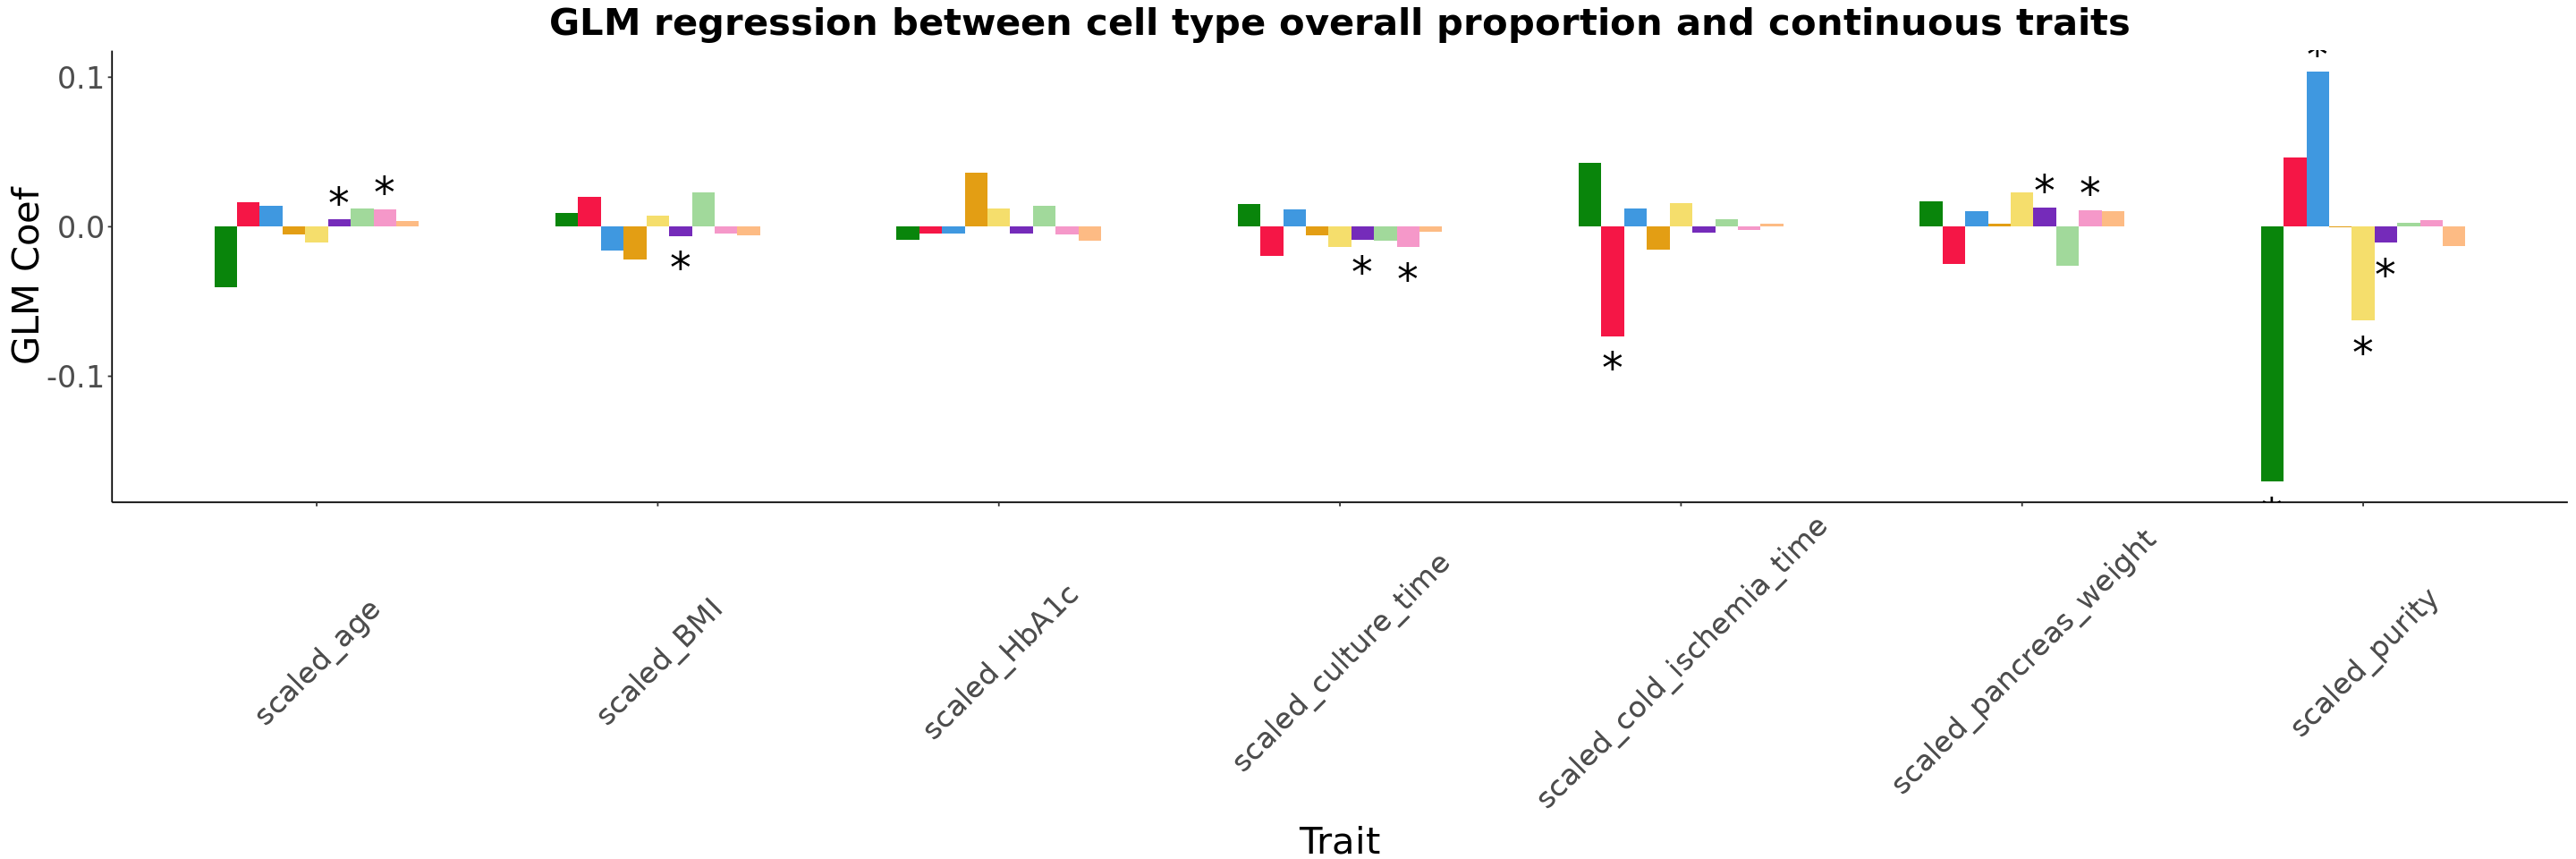

In [34]:
fp <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/proportions/metadata_total_prop_sqrt.multivar_glm.txt'
title <- 'GLM regression between cell type overall proportion and continuous traits'
plot_glm_summary(fp, title)

No id variables; using all as measure variables



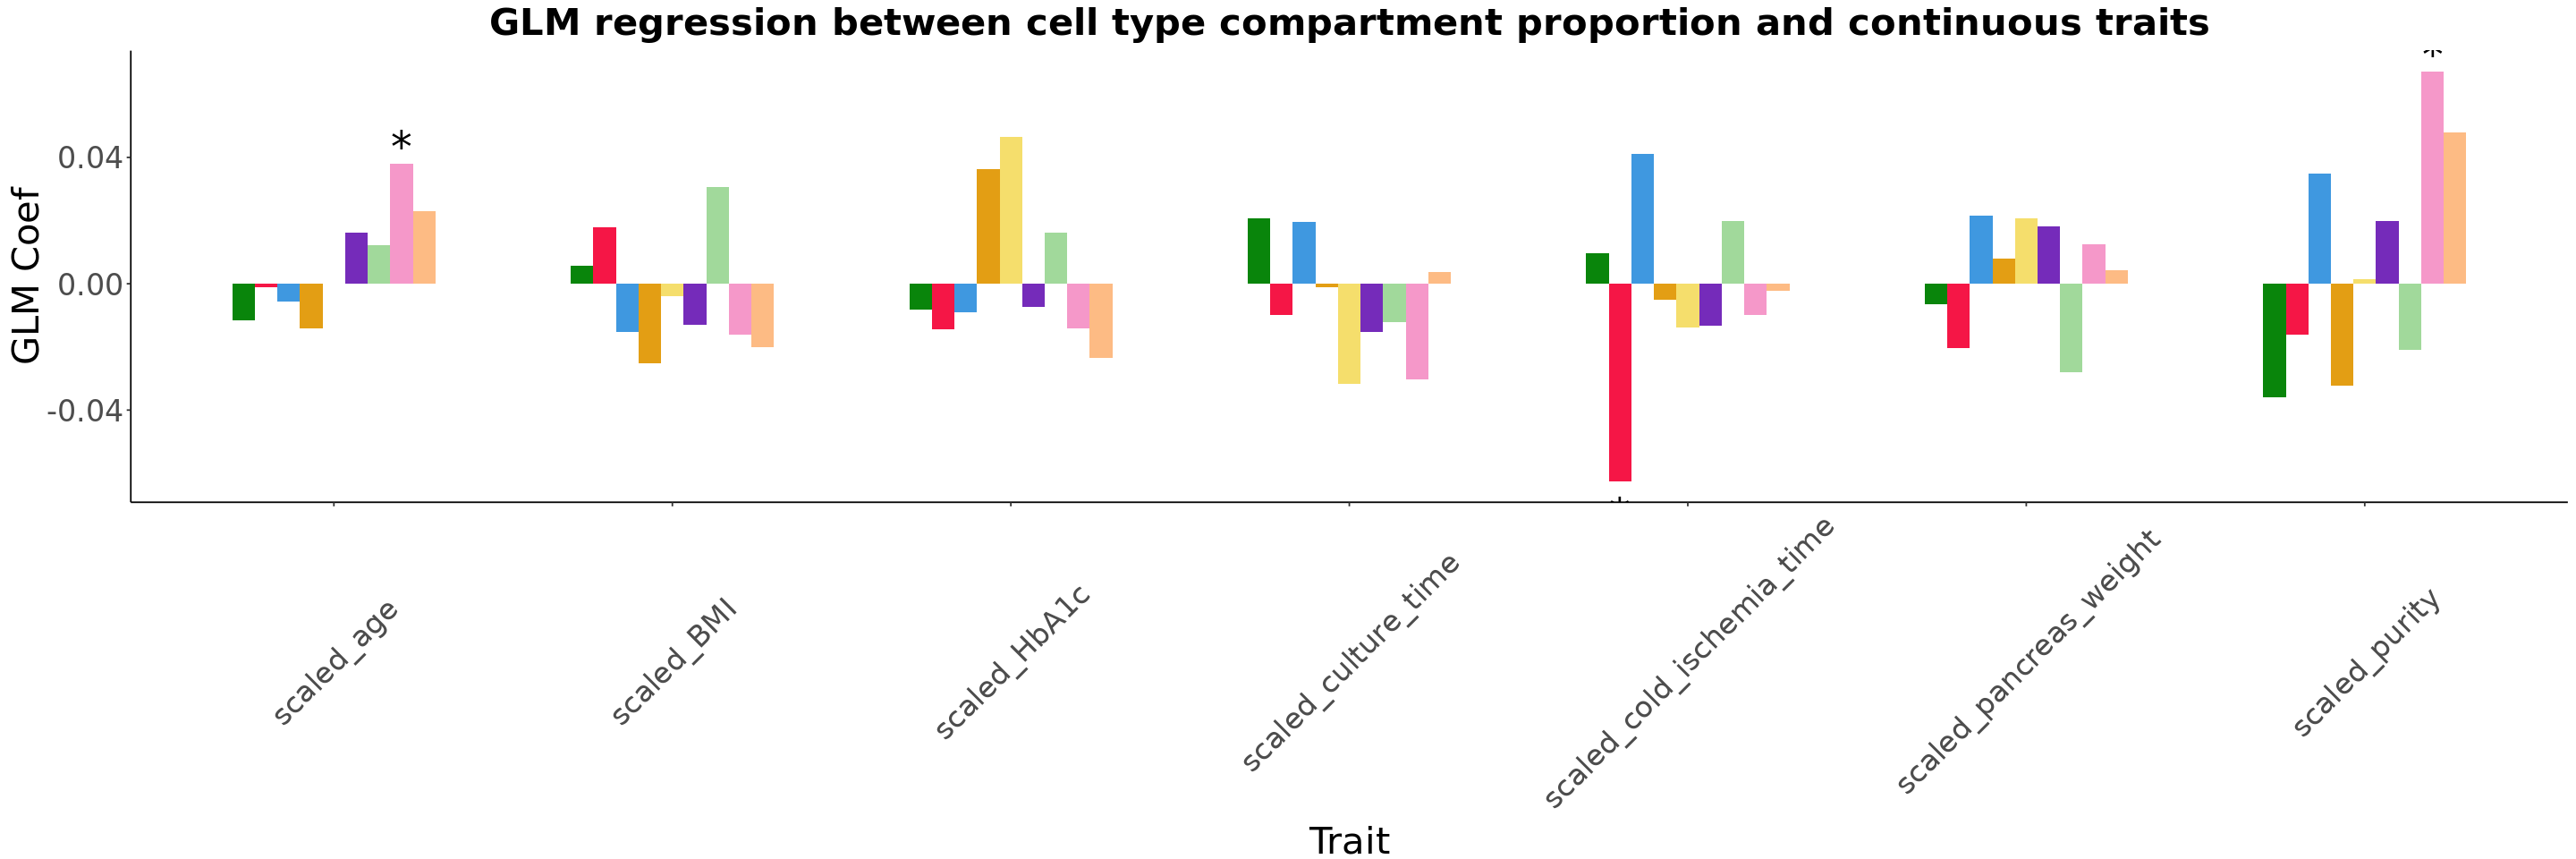

In [35]:
fp <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/proportions/metadata_comp_prop_sqrt.multivar_glm.txt'
title <- 'GLM regression between cell type compartment proportion and continuous traits'
plot_glm_summary(fp, title)

### anova results
high F-value means means of groups are more different (same with t-value)

In [36]:
### Function for reading in a glm output table and making a summary plot
plot_anova_summary <- function(fp, title, sig_cutoff=0.05){
    #read in file and format for plotting
    res2 <- read.table(fp, sep='\t', header=1)
    stat_colnames <- colnames(res2)[grepl('stat',colnames(res2))]
    pvalue_colnames <- colnames(res2)[grepl('pvalue',colnames(res2))]
    data <- cbind(reshape2::melt(as.matrix(res2[,stat_colnames])), reshape2::melt(res2[,pvalue_colnames])$value)
    colnames(data) <- c('feature', 'ct_prop', 'stat', 'pvalue')
    
    # Add in additional information needed for plotting
    data$celltype <- str_split_fixed(data$ct_prop, '\\.', 2)[,1]
    data$color <- major_colors[data$celltype]
    data$sig <- ifelse(data$pvalue <= sig_cutoff, '*', '')

    # Make grouped barplot of desired metadata
    options(repr.plot.width=12, repr.plot.height=6)
    theme_set(theme_classic())
    p1 <- ggplot(data, aes(fill=celltype, y=stat, x=feature)) + 
            geom_bar(position="dodge", width = 0.6, stat="identity") + 
            geom_text(aes(feature, stat, label=sig), position=position_dodge(width=0.6), size=10, vjust=-0.05) +
            labs(x = "Trait", y = "Stat (T-value or F-value)", color="Cell Type", title=title) + 
            scale_fill_manual(values=major_colors) +  
            theme(axis.text.x=element_text(size=18, vjust=0.5, angle=15),
                    axis.text.y=element_text(size=18, vjust=0.5),
                    axis.title.x = element_text(size=20, vjust=-0.35),
                    axis.title.y = element_text(size=20, vjust=0.5),
                    plot.title = element_text(size=20, hjust=0.5, face="bold"),
                    legend.position='none')
    print(p1)
}

No id variables; using all as measure variables



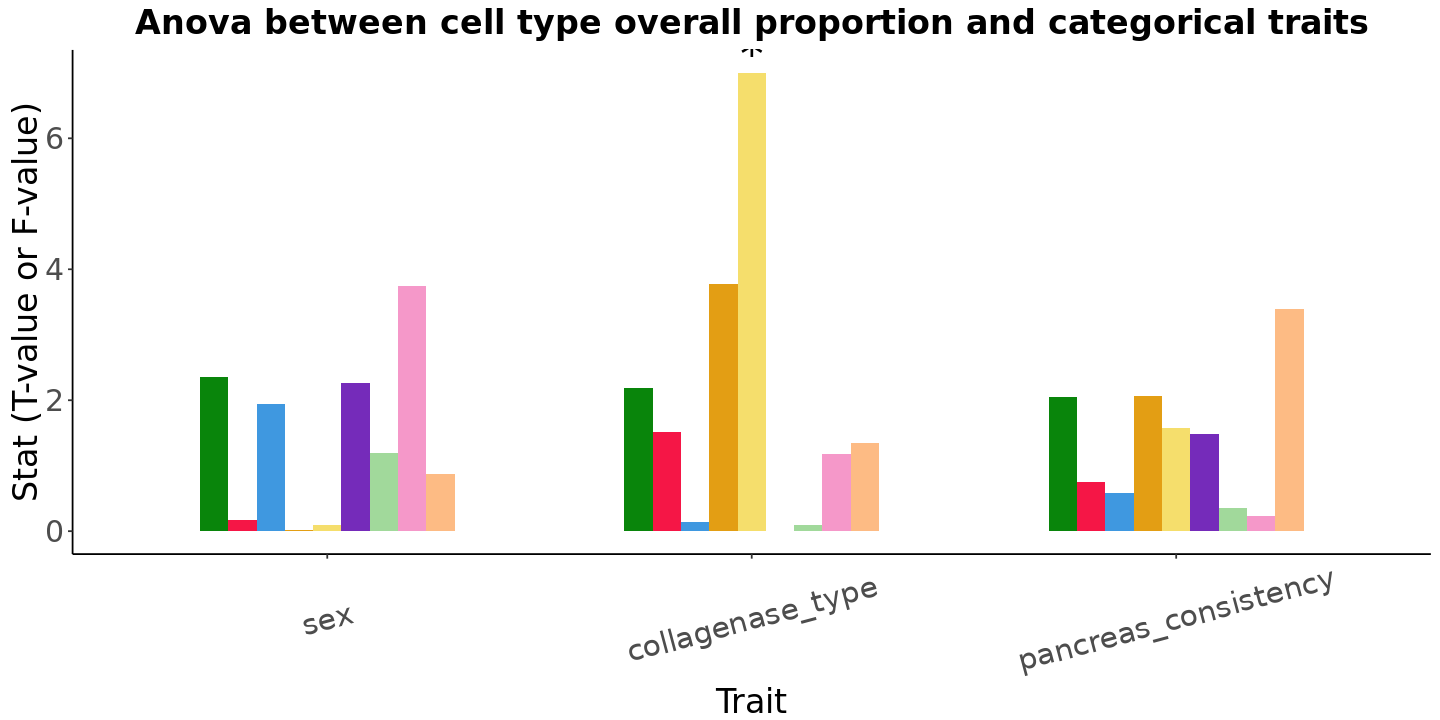

In [37]:
fp <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/proportions/metadata_total_prop_sqrt.anova_onesided.txt'
title <- 'Anova between cell type overall proportion and categorical traits'
plot_anova_summary(fp,title)

No id variables; using all as measure variables



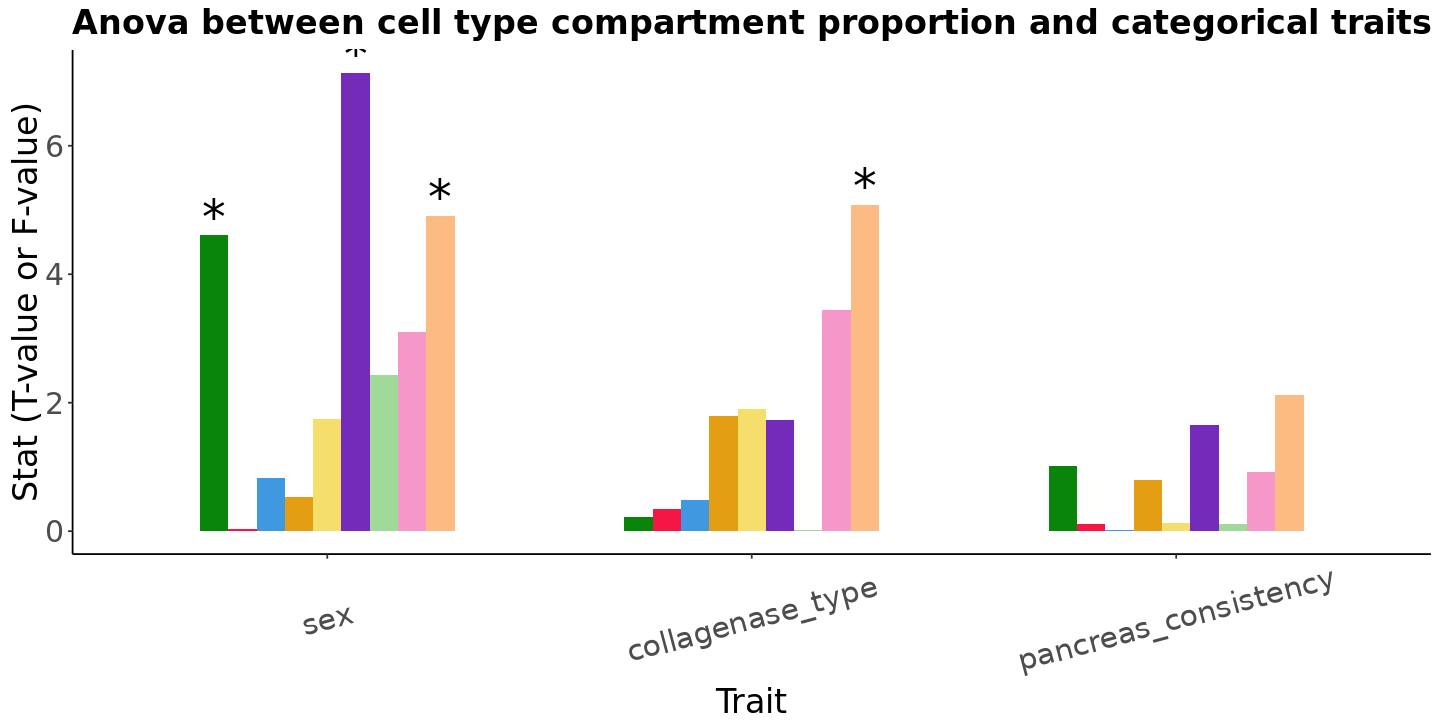

In [38]:
fp <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/proportions/metadata_comp_prop_sqrt.anova_onesided.txt'
title <- 'Anova between cell type compartment proportion and categorical traits'
plot_anova_summary(fp,title)

# Make plots for significant relationships of interest

In [65]:
### Function to compare the correlation of two columns in meta
### Also plots the relationship bt the two variables + a fit line?

compare_two_features <- function(meta, col1, col2, res_str, color, cont=TRUE){
    # Cut down dataframe for corr and ggplot 
    print(col1)
    print(col2)
    df <- meta[,c(col1, col2)]
    df <- df[!is.na(df[,col2]),]
    colnames(df) <- c('val1', 'val2')
    
    ### If is continuous variable make a scatter plot, otherwise make violin plot
    if(cont==TRUE){
        # Make basic plot to visualize relationship
        options(repr.plot.width=6, repr.plot.height=6)
        theme_set(
            theme_bw())
        p1 <- ggplot(data=df, aes(x=val1, y=val2)) + 
                geom_point(size=6, colour=color) + 
                labs(x = col1, y = col2, title=res_str) + 
                theme(axis.title=element_text(size=20),
                      axis.text.y=element_text(size=15),
                      axis.text.x=element_text(size=15, angle=30, vjust=0.5),
                      legend.title=element_text(size=15),
                      legend.text=element_text(size=15),
                      panel.grid.major=element_line(color='grey', size=0.5, linetype=2),
                      panel.grid.minor=element_blank(),
                      panel.border=element_rect(color='black',fill=NA, size=1))
    } else {
#         # Make custom colors for male (lighter color) vs. female (default color)
#         basic_pal <- colorRampPalette(colors = c('white',color))(3)
#         palette <- basic_pal[-1]
#         names(palette) <- c('Male', 'Female')

        # Make violinplot comparing cell type propotion across sex
        options(repr.plot.width=6, repr.plot.height=6)
        theme_set(
            theme_classic())

        p1 <- ggplot(data=df, aes(x=val2, y=val1)) + 
                geom_violin(trim=FALSE, fill=color) + 
                geom_boxplot(width=0.3, fill='white', alpha=.6) + 
                geom_dotplot(binaxis='y', stackdir='center', dotsize=1, fill='black') +
                labs(x = col2, y = col1, title=res_str) + 
                theme(axis.title=element_text(size=20),
                      axis.text.y=element_text(size=15),
                      axis.text.x=element_text(size=15, angle=30, vjust=0.5),
                      legend.title=element_text(size=15),
                      legend.text=element_text(size=15),
                      panel.grid.major=element_line(color='grey', size=0.5, linetype=2),
                      panel.grid.minor=element_blank(),
                      panel.border=element_rect(color='black',fill=NA, size=1))
    }
    return(p1)
}

In [43]:
wrapper_plot_sig_assocs <- function(meta, run_prefix, sig_cutoff=0.05){
    #read in data and remake meta_fin
    data_fp <- file.path(outdir, 'props_tables', sprintf('Alberta_celltype_%s.txt',run_prefix))
    df <- read.table(data_fp, sep='\t', header=1)
    meta_fin <- cbind(meta, df)
    meta_fin <- meta_fin[row.names(meta_fin) != 'R316',]
    meta_fin <- meta_fin[row.names(meta_fin) != 'R275',]

    # read in GLM results and plot sig associations
    res_fp <- file.path(outdir, sprintf('metadata_%s.multivar_glm.txt', run_prefix))
    res_df <- read.table(res_fp, sep='\t')

    for (celltype in celltypes){
        for(trait in cont_vars){
            res_col1 <- paste0(celltype,'_',run_prefix,'_coef') ### update per test
            res_col2 <- paste0(celltype,'_',run_prefix,'_pvalue') ### update per test
            stat <- res_df[trait,res_col1]
            pval <- res_df[trait,res_col2]
            if (pval < sig_cutoff){
                res_str <- sprintf('sig GLM (%s, pvalue=%s)',substr(stat,1,4),substr(pval,1,4))
                p1 <- compare_two_features(meta_fin, paste(celltype,run_prefix,sep='_'), trait, res_str, major_colors[[celltype]], TRUE)
                print(p1)
            }
        }
    }   

    #read in ANOVA results and plot sig associations
    res_fp <- file.path(outdir, sprintf('metadata_%s.anova_onesided.txt',run_prefix))
    res_df <- read.table(res_fp, sep='\t')
    
    for (celltype in celltypes){
        for(trait in categ_covars){
            res_col1 <- paste0(celltype,'.stat') ### update per test
            res_col2 <- paste0(celltype,'.pvalue') ### update per test
            stat <- res_df[trait,res_col1]
            pval <- res_df[trait,res_col2]
            if (pval < sig_cutoff){
                res_str <- sprintf('sig ANOVA (%s, pvalue=%s)',substr(stat,1,4),substr(pval,1,4))
                p1 <- compare_two_features(meta_fin, paste0(celltype,'_',run_prefix), trait, res_str, major_colors[[celltype]], FALSE)
                print(p1)
            }
        }
    }
}

[1] "beta_total_prop_sqrt"
[1] "scaled_purity"
[1] "alpha_total_prop_sqrt"
[1] "scaled_cold_ischemia_time"


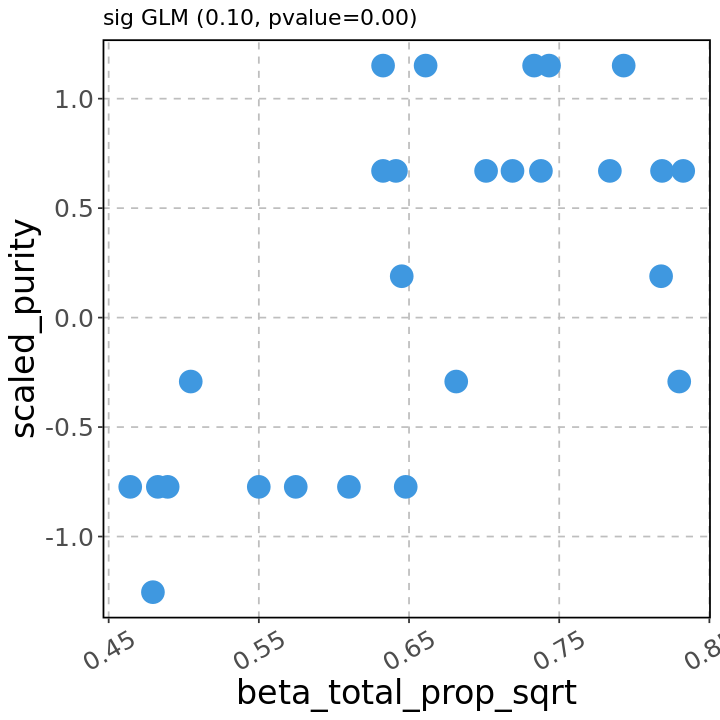

[1] "acinar_total_prop_sqrt"
[1] "scaled_purity"


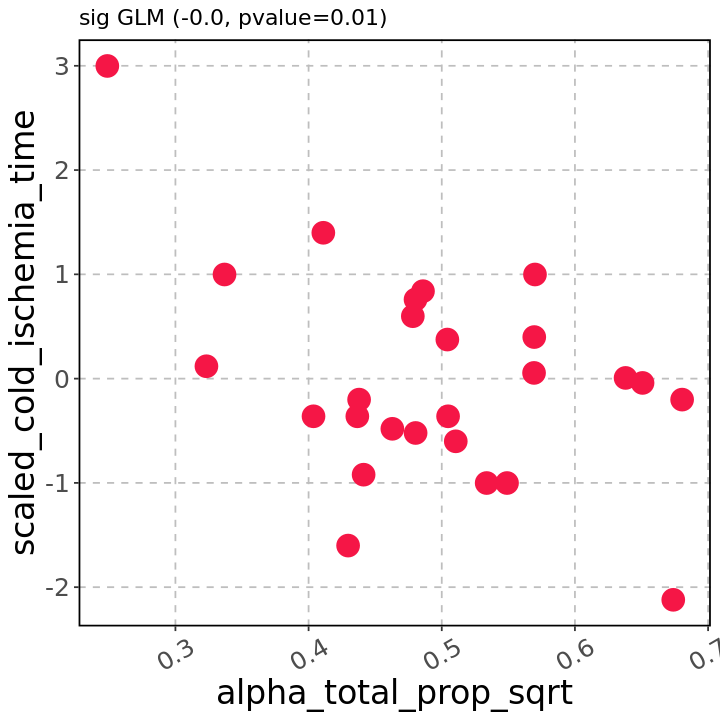

[1] "ductal_total_prop_sqrt"
[1] "scaled_purity"


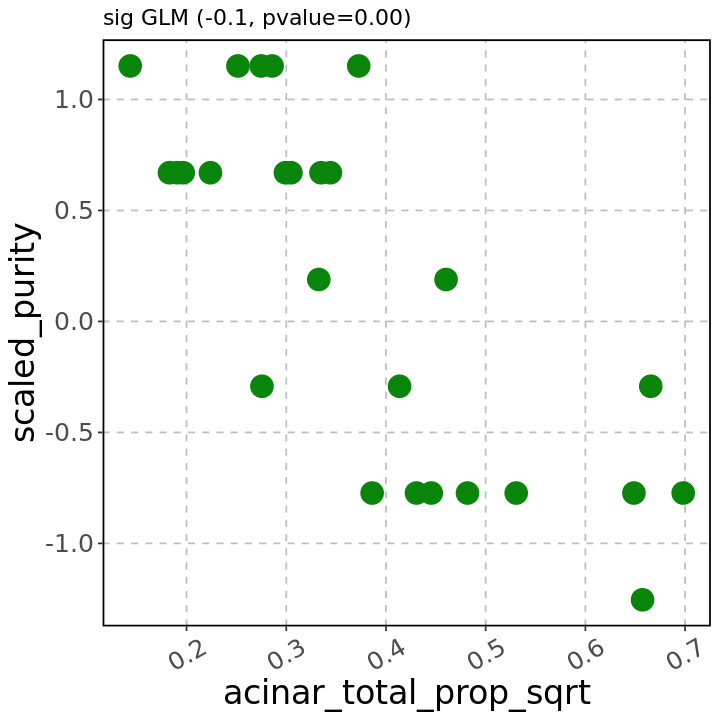

[1] "endothelial_total_prop_sqrt"
[1] "scaled_age"


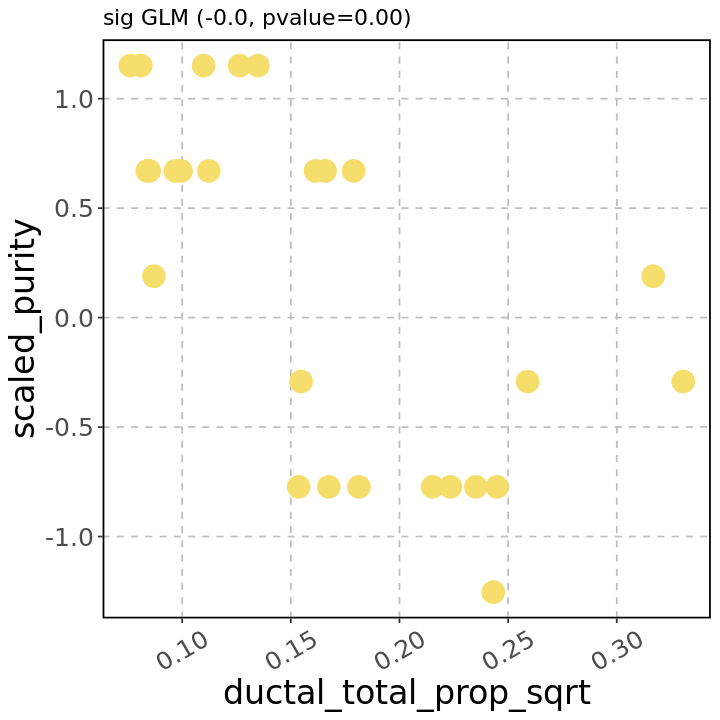

[1] "endothelial_total_prop_sqrt"
[1] "scaled_BMI"


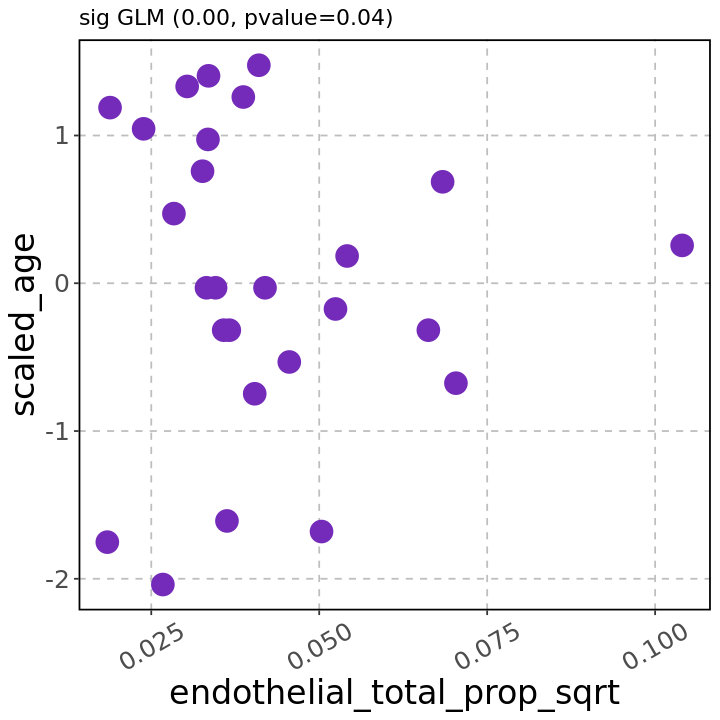

[1] "endothelial_total_prop_sqrt"
[1] "scaled_culture_time"


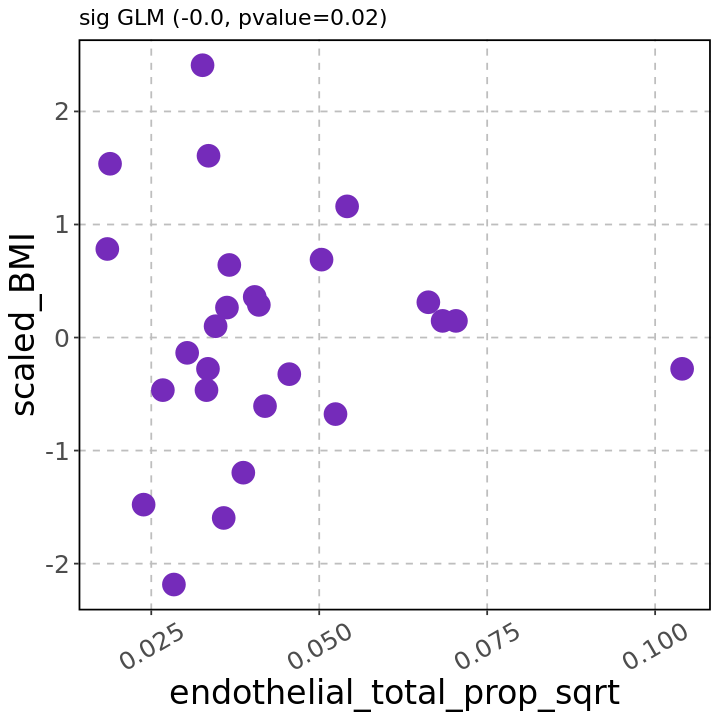

[1] "endothelial_total_prop_sqrt"
[1] "scaled_pancreas_weight"


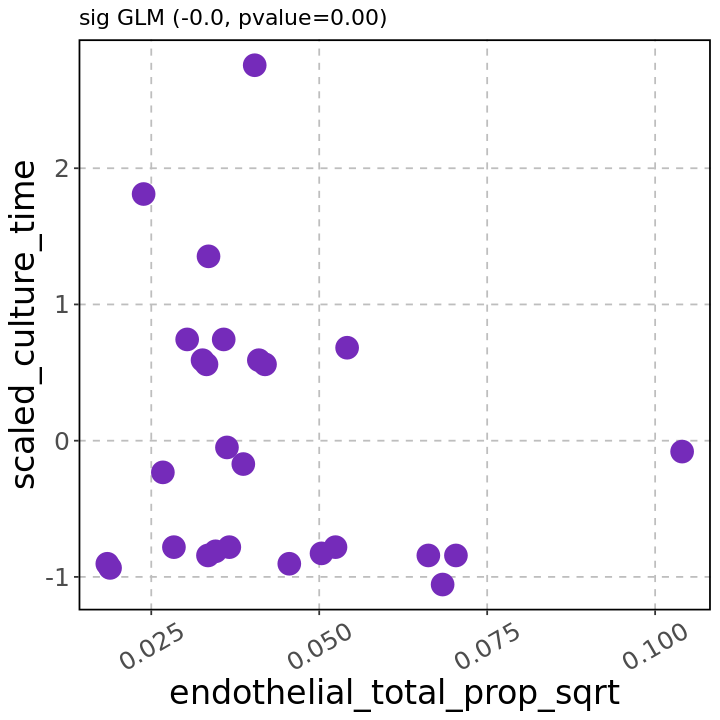

[1] "endothelial_total_prop_sqrt"
[1] "scaled_purity"


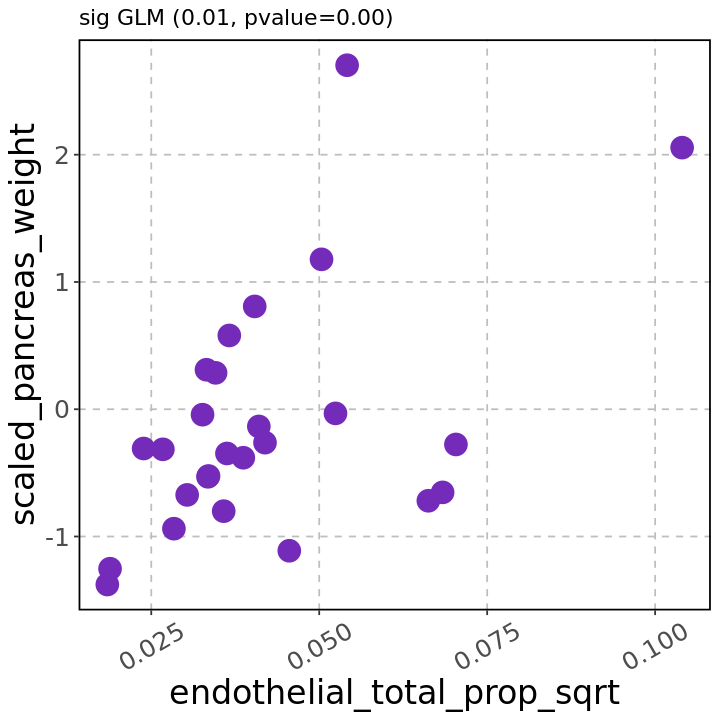

[1] "immune_total_prop_sqrt"
[1] "scaled_age"


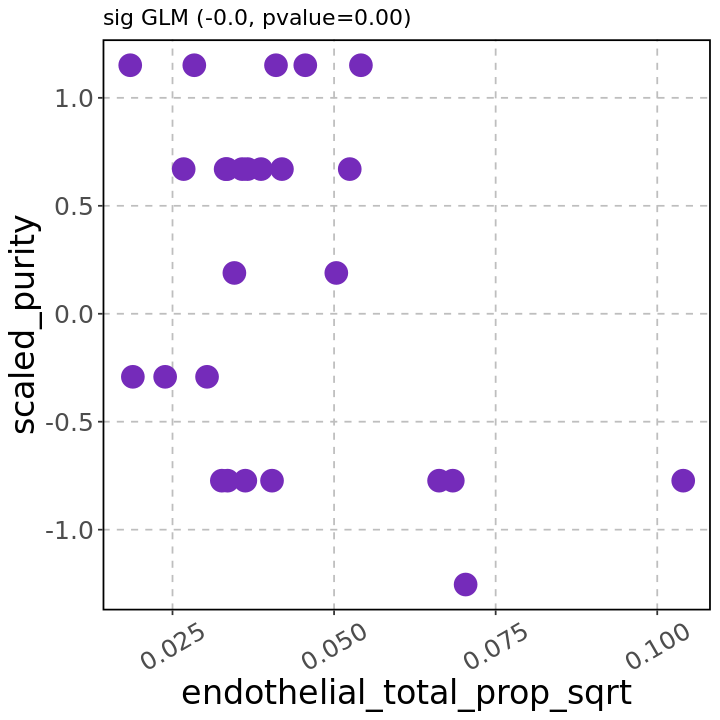

[1] "immune_total_prop_sqrt"
[1] "scaled_culture_time"


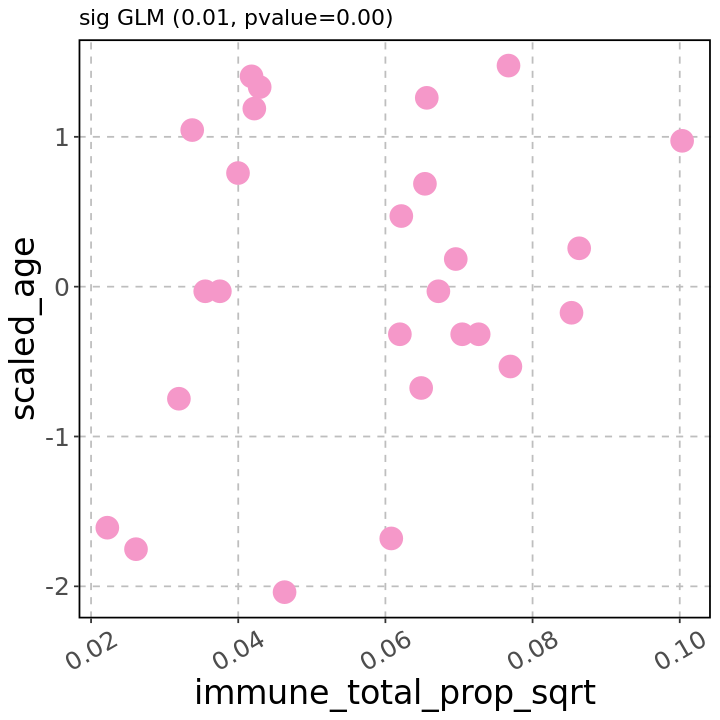

[1] "immune_total_prop_sqrt"
[1] "scaled_pancreas_weight"


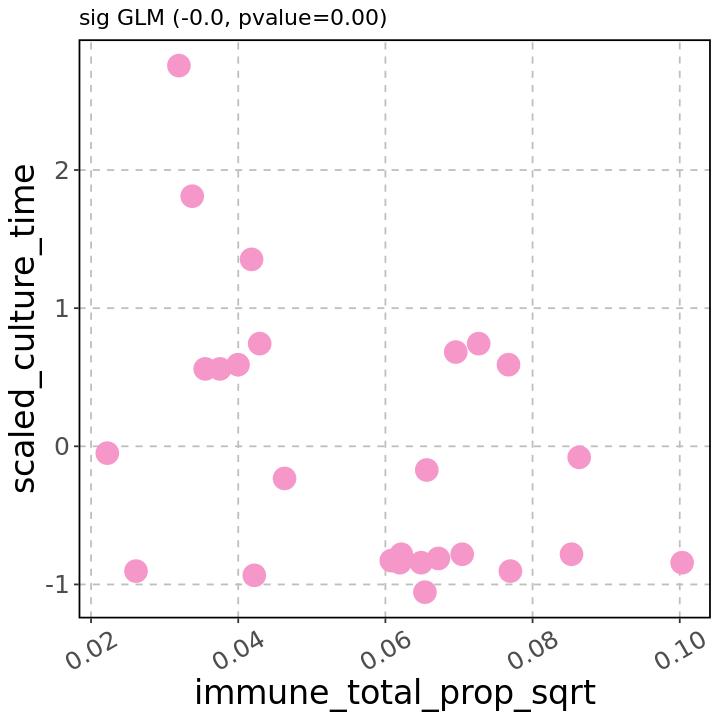

[1] "ductal_total_prop_sqrt"
[1] "collagenase_type"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


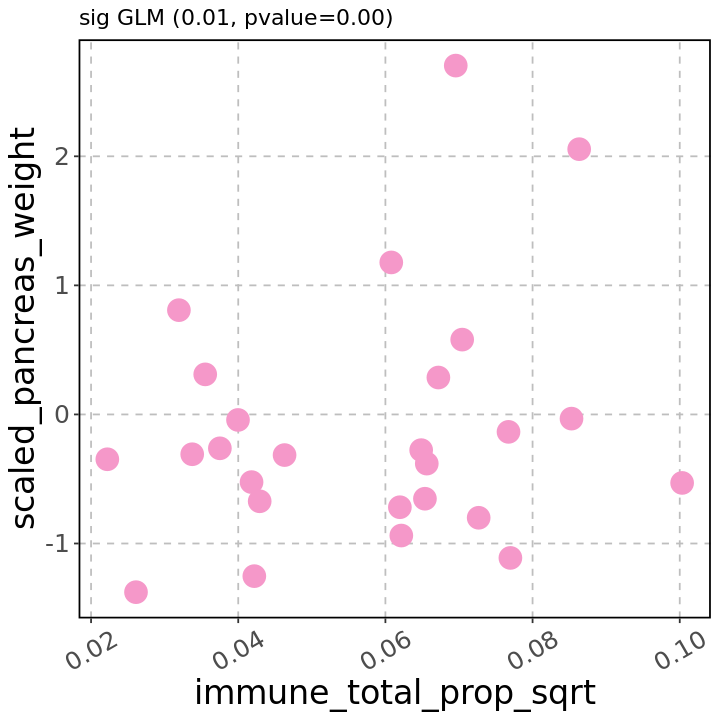

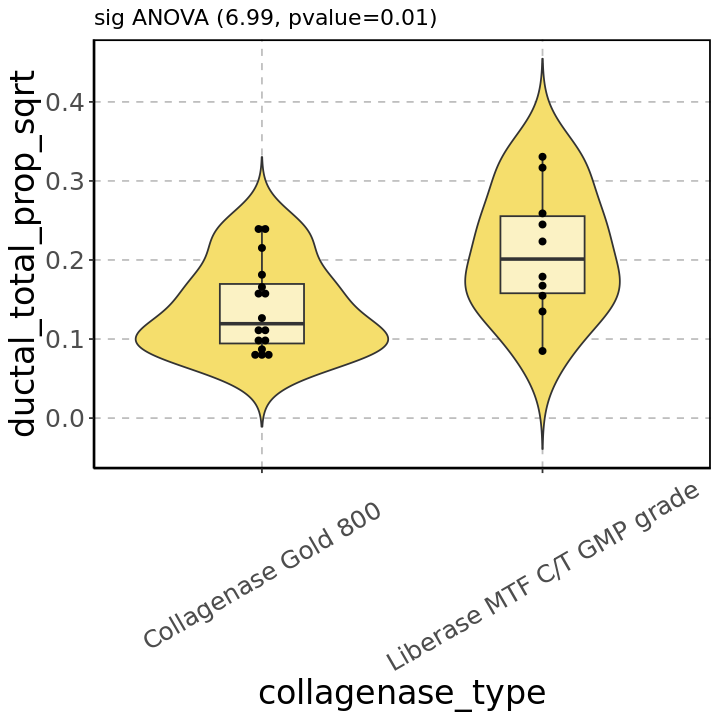

In [66]:
wrapper_plot_sig_assocs(meta, 'total_prop_sqrt')

[1] "alpha_comp_prop_sqrt"
[1] "scaled_cold_ischemia_time"
[1] "immune_comp_prop_sqrt"
[1] "scaled_age"


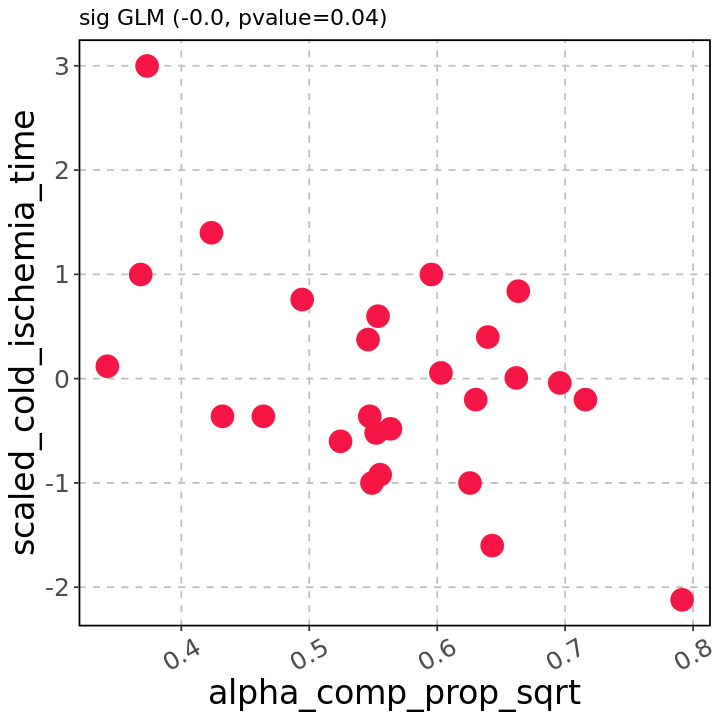

[1] "immune_comp_prop_sqrt"
[1] "scaled_purity"


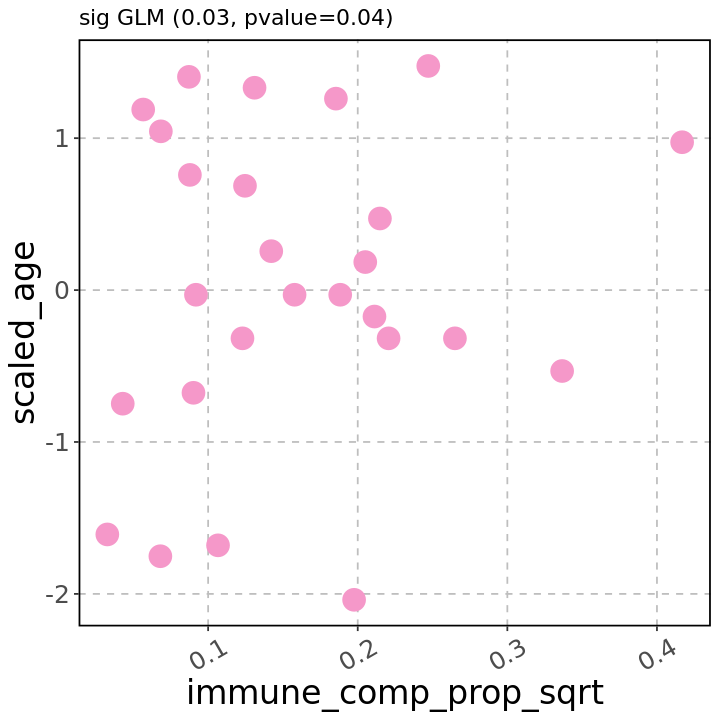

[1] "acinar_comp_prop_sqrt"
[1] "sex"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


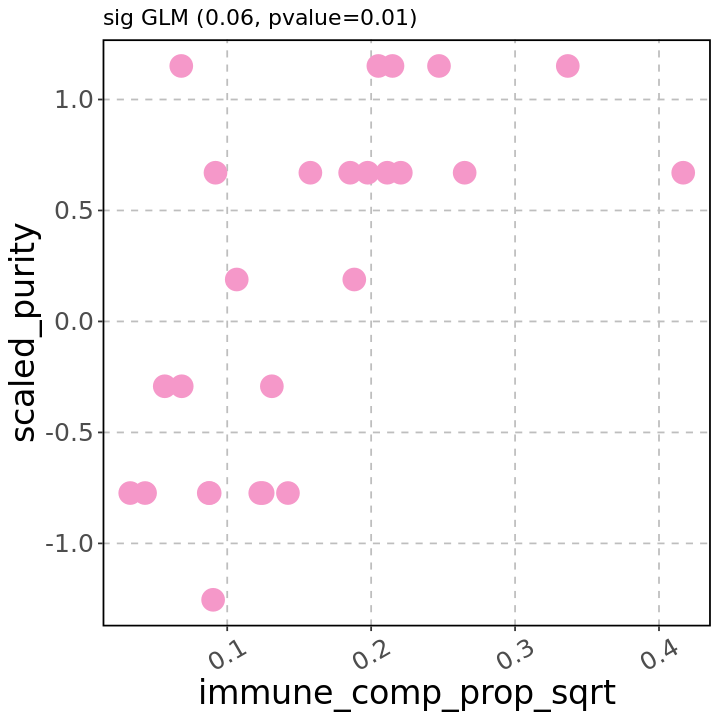

[1] "endothelial_comp_prop_sqrt"
[1] "sex"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


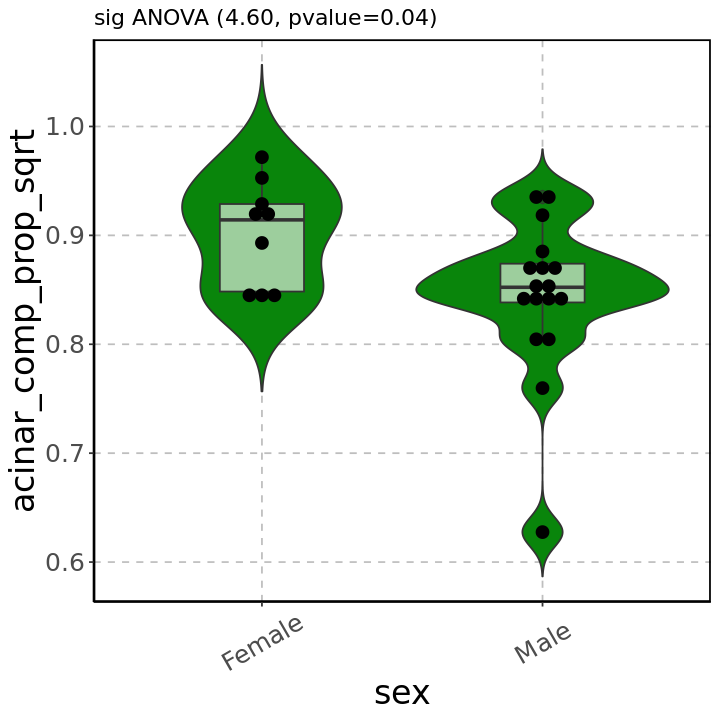

[1] "stellate_comp_prop_sqrt"
[1] "sex"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


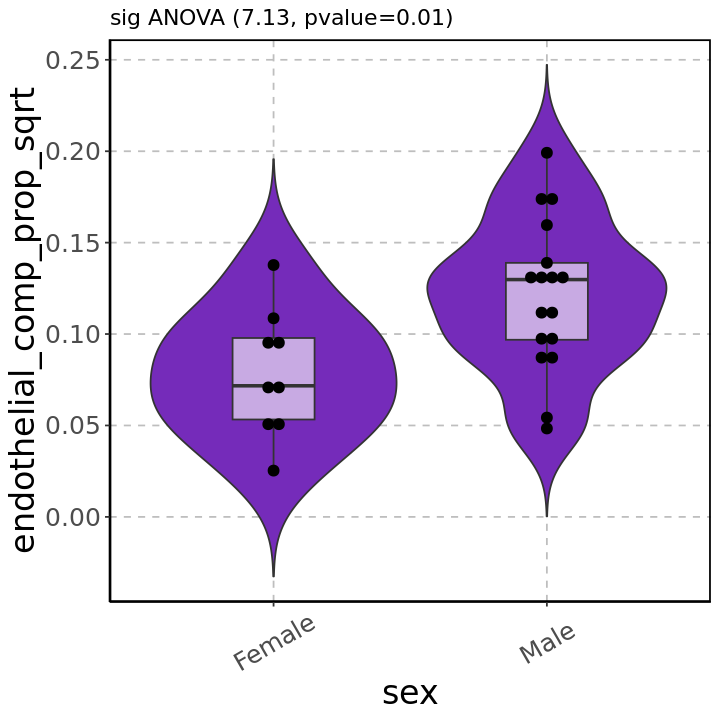

[1] "stellate_comp_prop_sqrt"
[1] "collagenase_type"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


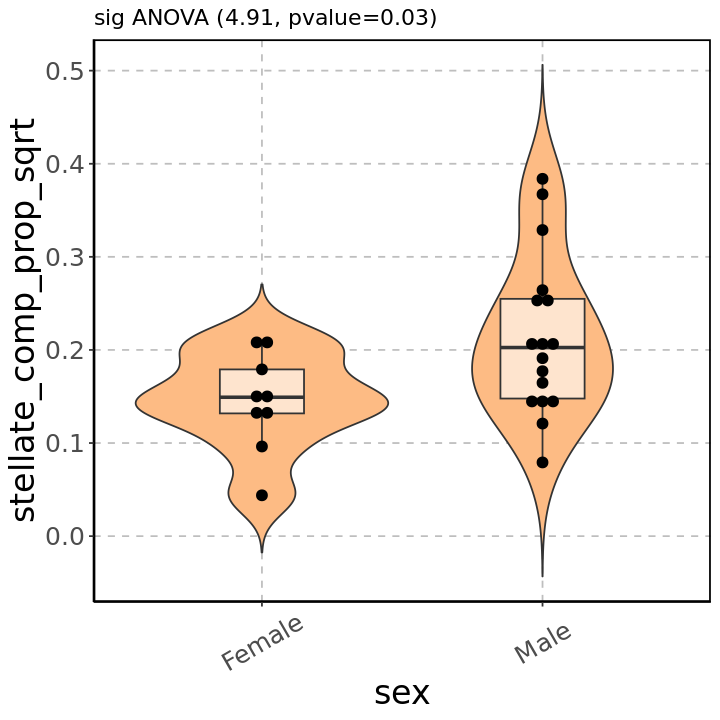

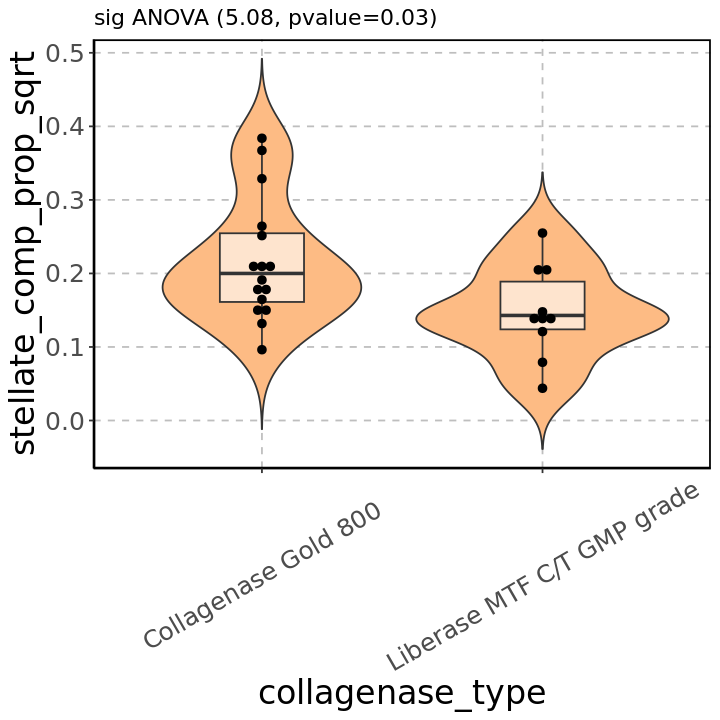

In [67]:
wrapper_plot_sig_assocs(meta, 'comp_prop_sqrt')

## Also make plots for interesting relationships that didn't reach significance

Overall prop:
- acinar + age
- beta + HbA1c
- delta + HbA1c
- sex vs. acinar, beta, endo, immune
- collagenase type vs. acinar, alpha, delta
- pancreas consistency vs. acinar, delta, ductal, endo, stellate

Per compartment prop: 
- alpha + BMI
- gamma + BMI
- delta + HbA1c
- ductal + HbA1c
- sex vs. gamma, immune
- collagenase type vs. immune
- pancreas consistency vs. acinar, delta, endo, stellate

In [62]:
wrapper_plot_other_assocs <- function(run_prefix, cont_comps, disc_comps, meta, sig_cutoff=0.05){
    #read in data and remake meta_fin
    data_fp <- file.path(outdir, 'props_tables', sprintf('Alberta_celltype_%s.txt',run_prefix))
    df <- read.table(data_fp, sep='\t', header=1)
    meta_fin <- cbind(meta, df)
    meta_fin <- meta_fin[row.names(meta_fin) != 'R316',]
    meta_fin <- meta_fin[row.names(meta_fin) != 'R275',]
    print(dim(meta_fin))

    # read in GLM results
    res_fp <- file.path(outdir, sprintf('metadata_%s.multivar_glm.txt', run_prefix))
    res_df <- read.table(res_fp, sep='\t')
    
    #make single plots for comparisons with cont covars
    for(comp in cont_comps){
        celltype <- unlist(str_split(comp[1],'\\+'))[1]
        trait <- unlist(str_split(comp[1],'\\+'))[2]
        res_col1 <- paste0(celltype,'_',run_prefix,'_coef') ### update per test
        res_col2 <- paste0(celltype,'_',run_prefix,'_pvalue') ### update per test
        stat <- res_df[trait,res_col1]
        pval <- res_df[trait,res_col2]
        res_str <- sprintf('Non-sig GLM (%s, pvalue=%s)',substr(stat,1,6),substr(pval,1,4))
        p1 <- compare_two_features(meta_fin, paste(celltype,run_prefix,sep='_'), trait, res_str, major_colors[[celltype]], TRUE)
        print(p1)
    }

    #read in ANOVA results and plot sig associations
    res_fp <- file.path(outdir, sprintf('metadata_%s.anova_onesided.txt',run_prefix))
    res_df <- read.table(res_fp, sep='\t')
    
    #make single plots for comparisons with discrete covars
    for(comp in disc_comps){
        celltype <- unlist(str_split(comp[1],'\\+'))[1]
        trait <- unlist(str_split(comp[1],'\\+'))[2]
        res_col1 <- paste0(celltype,'.stat') ### update per test
        res_col2 <- paste0(celltype,'.pvalue') ### update per test
        stat <- res_df[trait,res_col1]
        pval <- res_df[trait,res_col2]
        res_str <- sprintf('Non-sig ANOVA (%s, pvalue=%s)',substr(stat,1,6),substr(pval,1,4))
        p1 <- compare_two_features(meta_fin, paste0(celltype,'_',run_prefix), trait, res_str, major_colors[[celltype]], FALSE)
        print(p1)
    }
}

[1] 26 35
[1] "acinar_total_prop_sqrt"
[1] "scaled_age"
[1] "beta_total_prop_sqrt"
[1] "scaled_HbA1c"


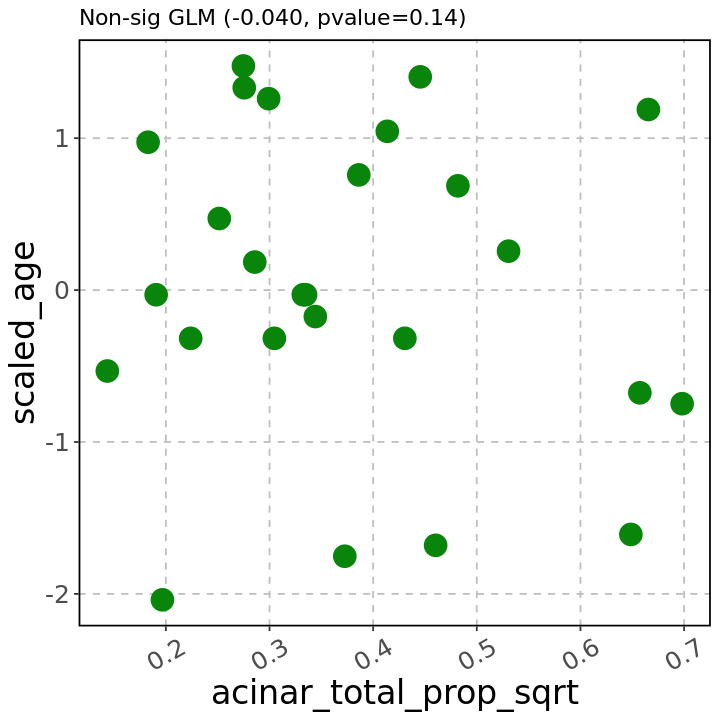

[1] "delta_total_prop_sqrt"
[1] "scaled_HbA1c"


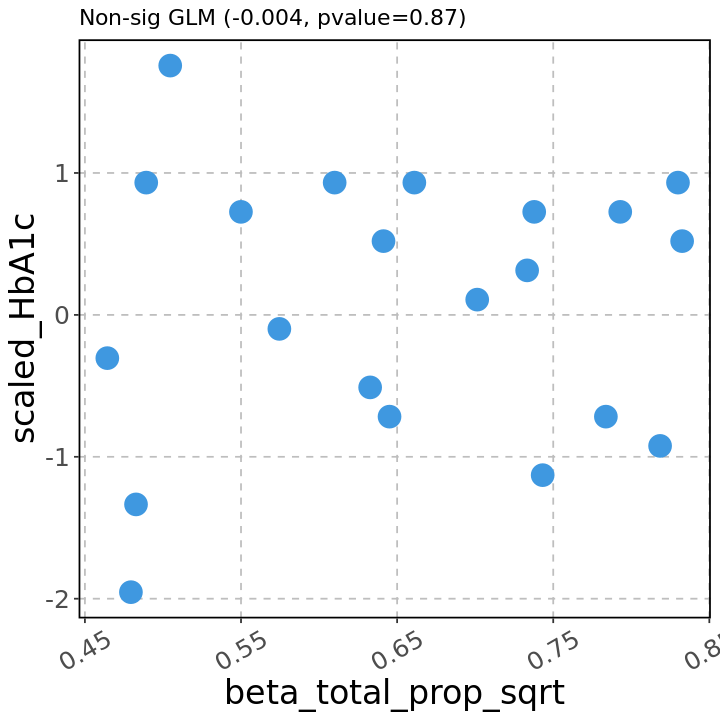

[1] "acinar_total_prop_sqrt"
[1] "sex"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


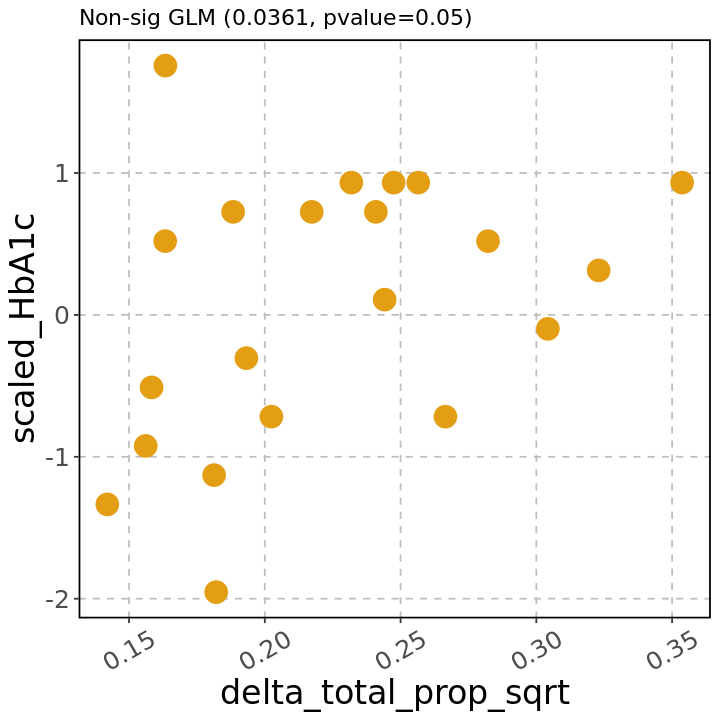

[1] "beta_total_prop_sqrt"
[1] "sex"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


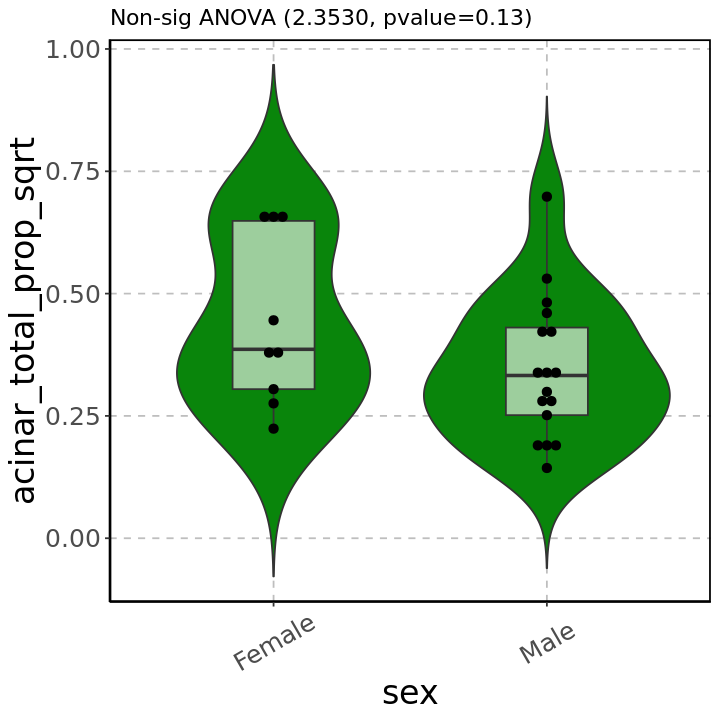

[1] "endothelial_total_prop_sqrt"
[1] "sex"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


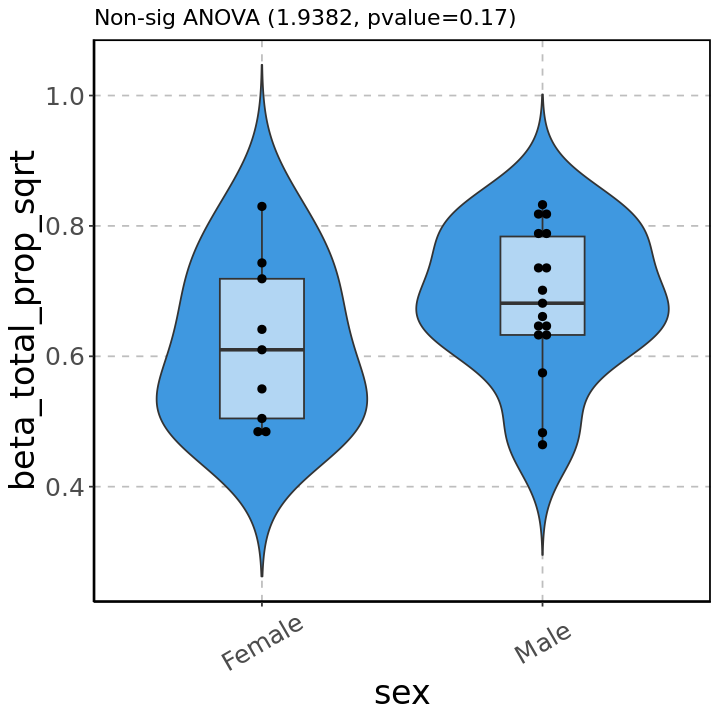

[1] "immune_total_prop_sqrt"
[1] "sex"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


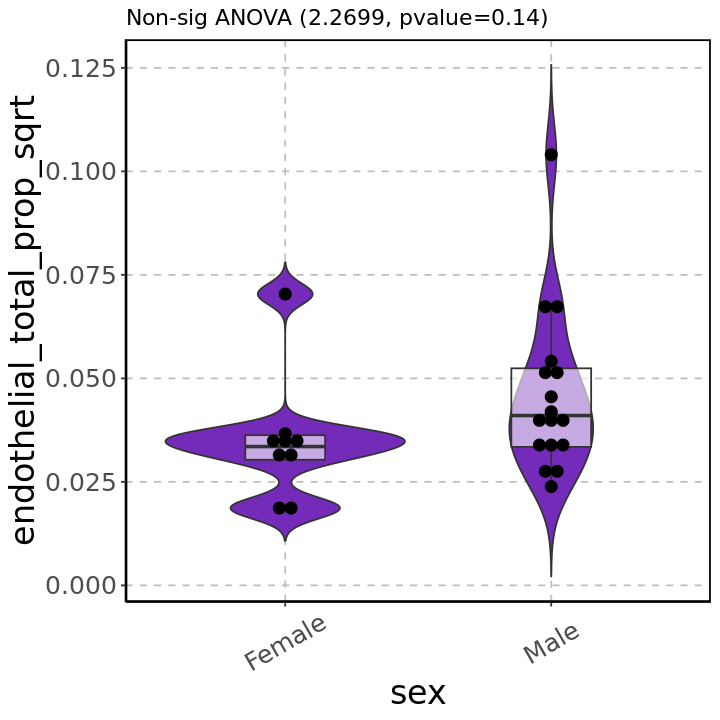

[1] "acinar_total_prop_sqrt"
[1] "collagenase_type"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


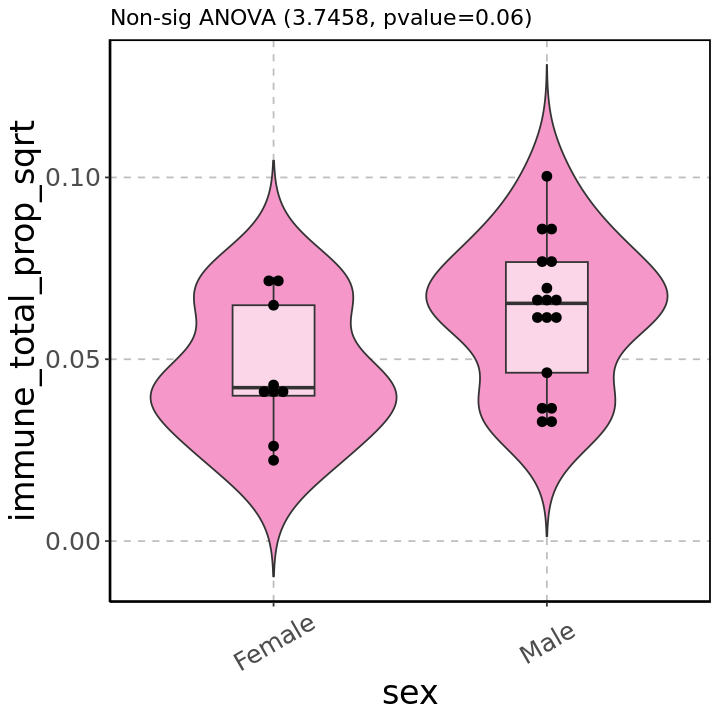

[1] "alpha_total_prop_sqrt"
[1] "collagenase_type"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


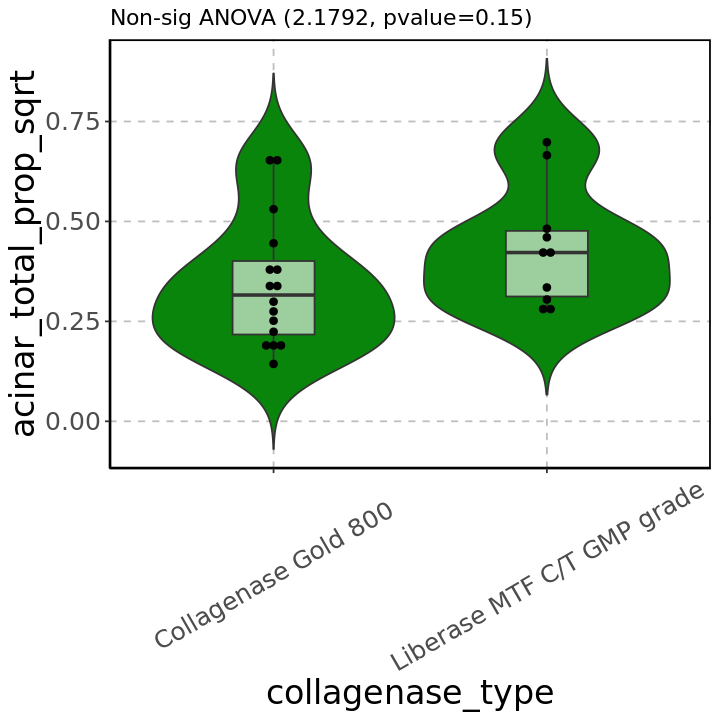

[1] "delta_total_prop_sqrt"
[1] "collagenase_type"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


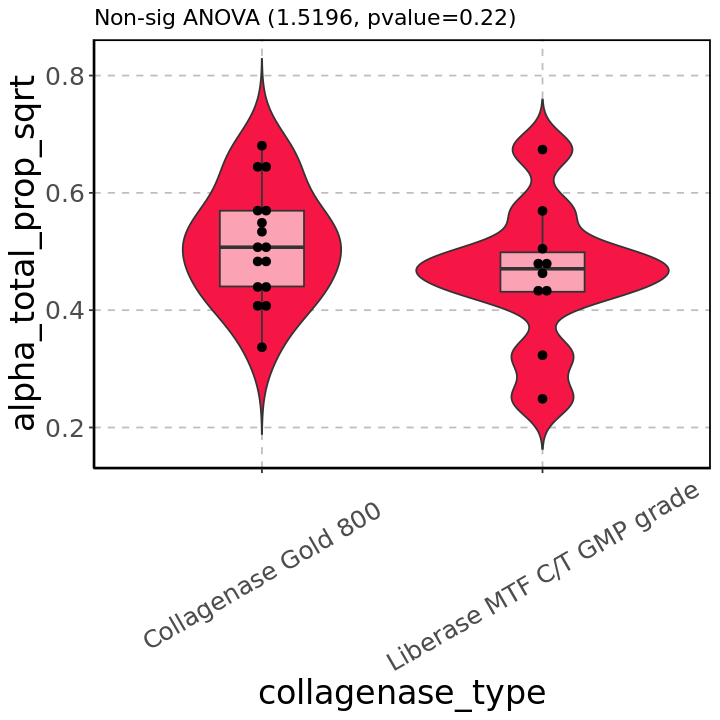

[1] "acinar_total_prop_sqrt"
[1] "pancreas_consistency"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


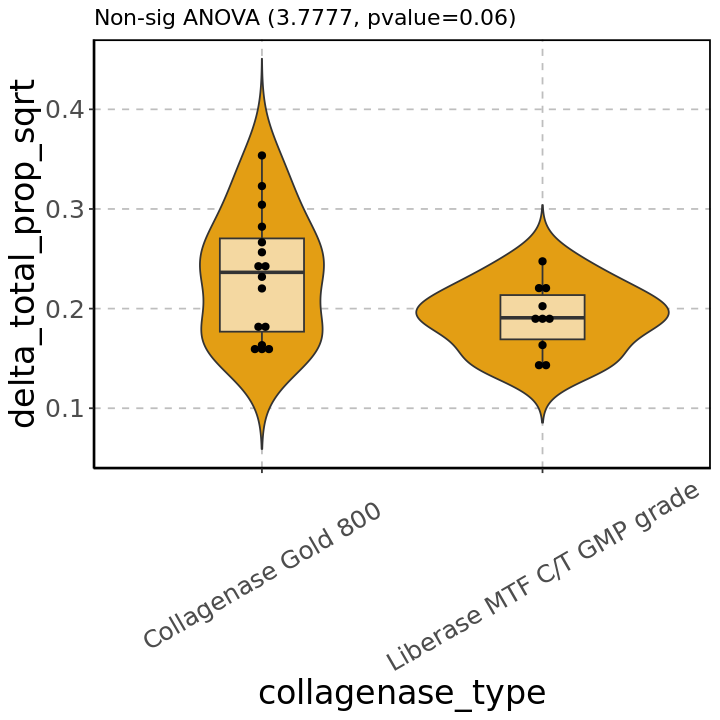

[1] "delta_total_prop_sqrt"
[1] "pancreas_consistency"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


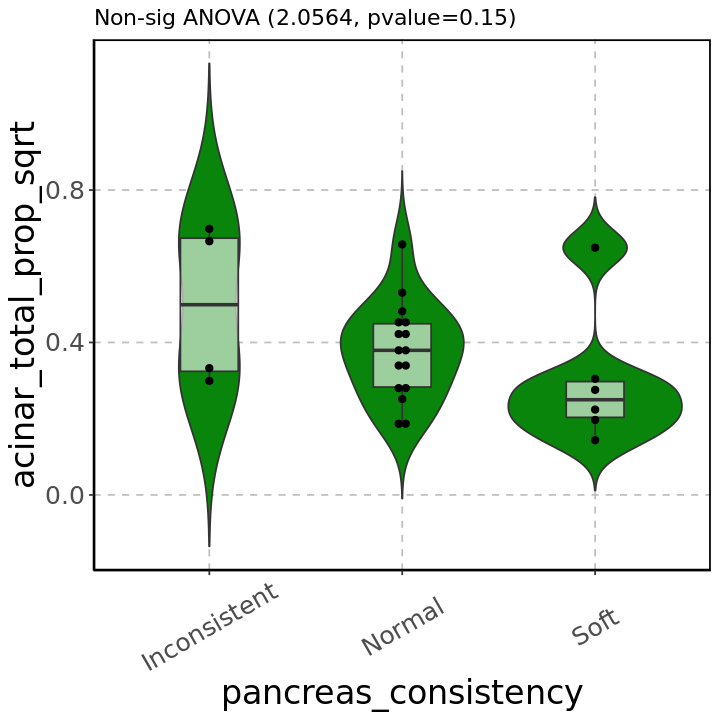

[1] "ductal_total_prop_sqrt"
[1] "pancreas_consistency"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


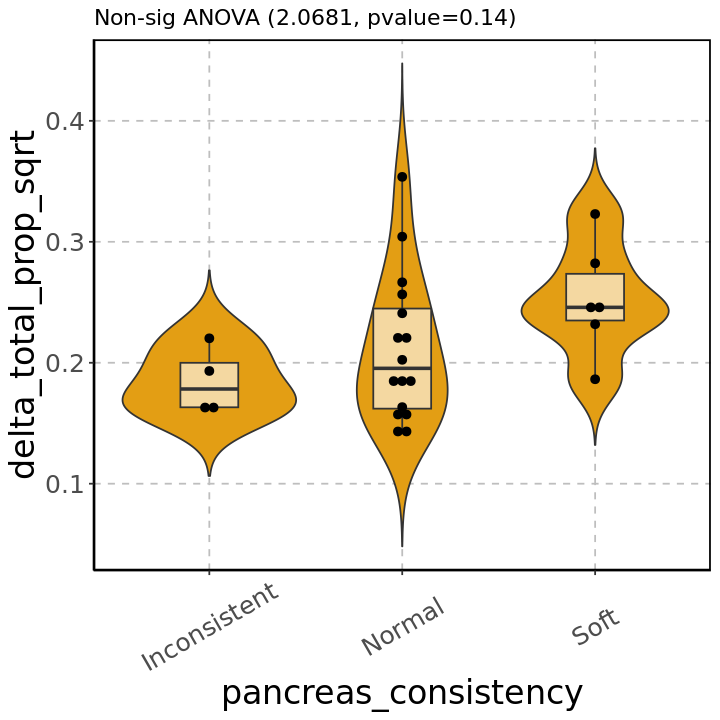

[1] "endothelial_total_prop_sqrt"
[1] "pancreas_consistency"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


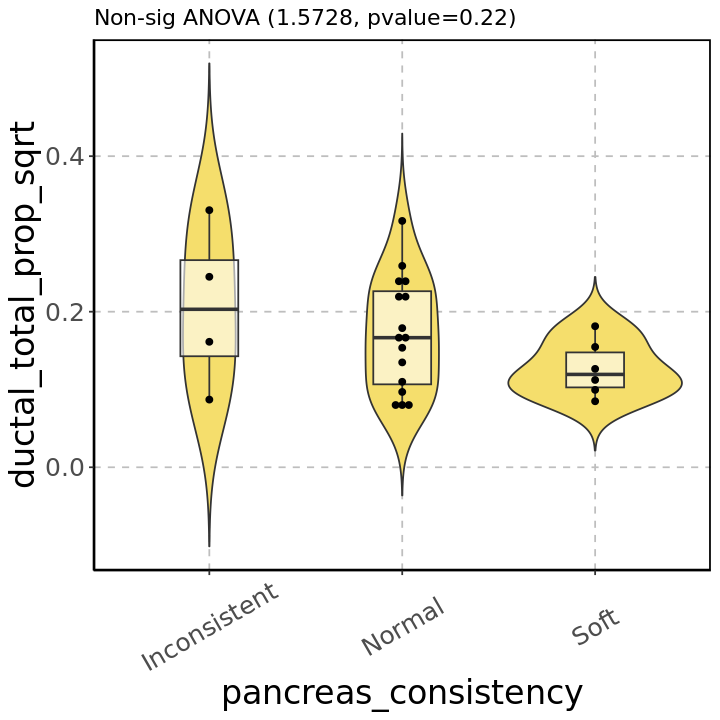

[1] "stellate_total_prop_sqrt"
[1] "pancreas_consistency"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


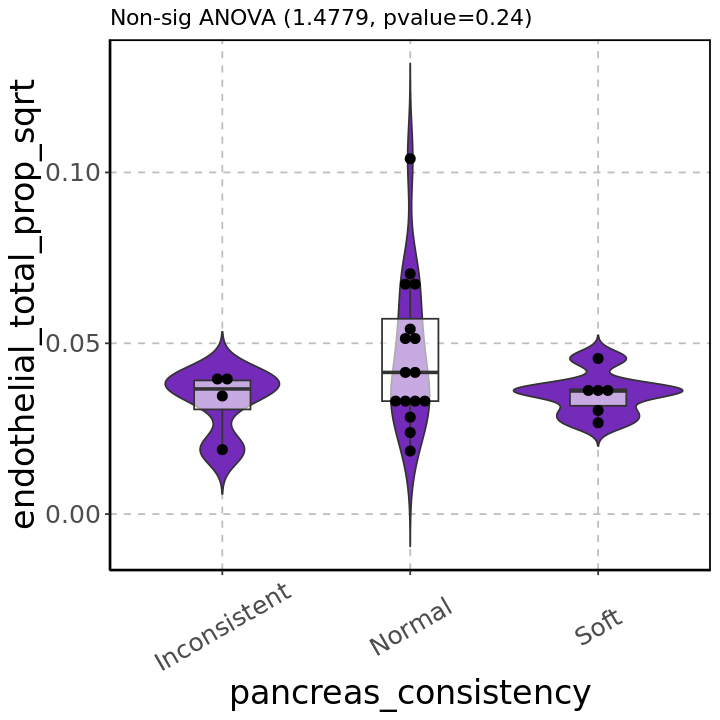

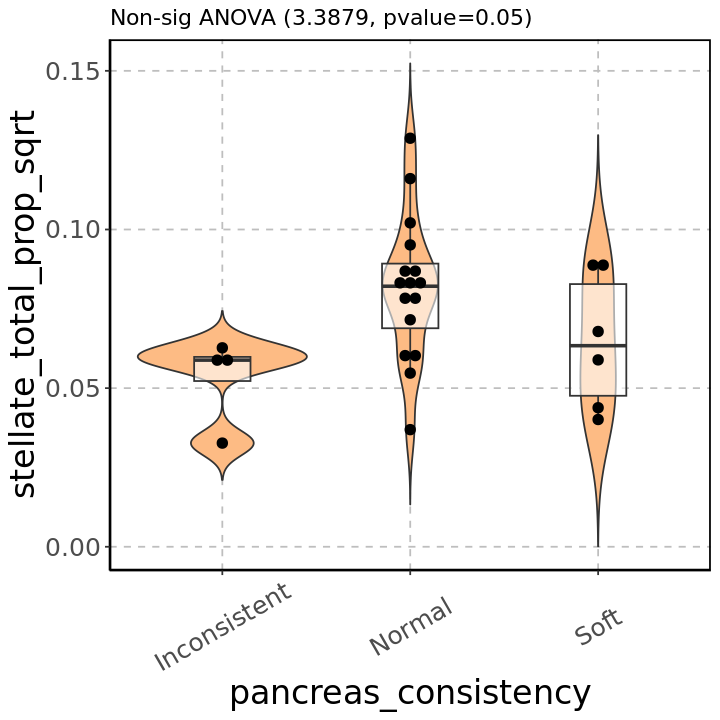

In [68]:
run_prefix <- 'scaled_counts'
comps1 <- c('acinar+scaled_age','beta+scaled_HbA1c','delta+scaled_HbA1c')
comps2 <- c('acinar+sex','beta+sex','endothelial+sex','immune+sex',
            'acinar+collagenase_type','alpha+collagenase_type','delta+collagenase_type',
            'acinar+pancreas_consistency','delta+pancreas_consistency', 'ductal+pancreas_consistency',
            'endothelial+pancreas_consistency','stellate+pancreas_consistency')

wrapper_plot_other_assocs('total_prop_sqrt', comps1, comps2, meta)

[1] 26 35
[1] "alpha_comp_prop_sqrt"
[1] "scaled_age"
[1] "gamma_comp_prop_sqrt"
[1] "scaled_BMI"


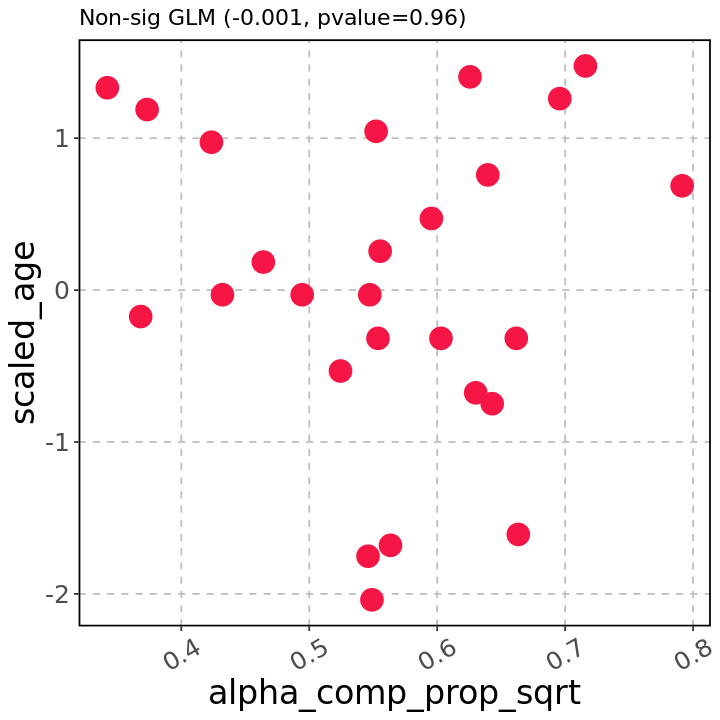

[1] "delta_comp_prop_sqrt"
[1] "scaled_HbA1c"


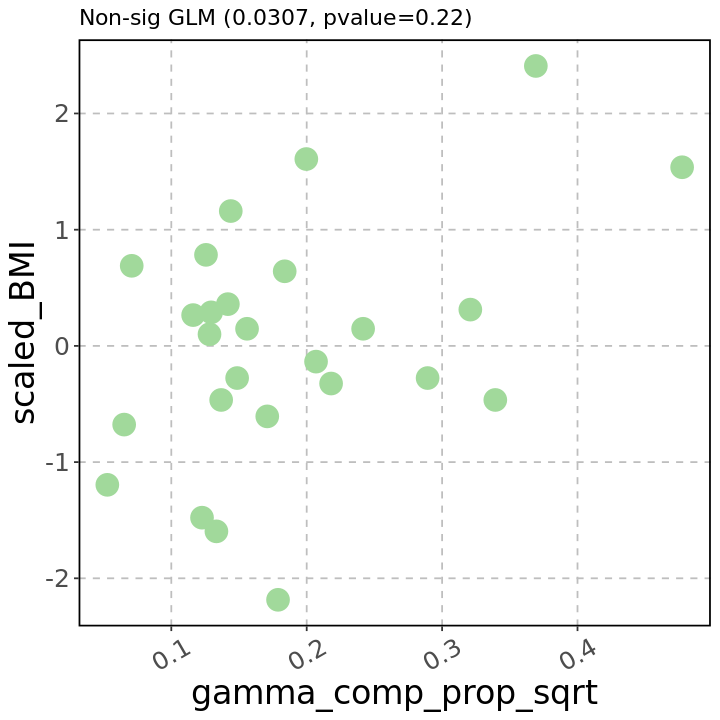

[1] "ductal_comp_prop_sqrt"
[1] "scaled_HbA1c"


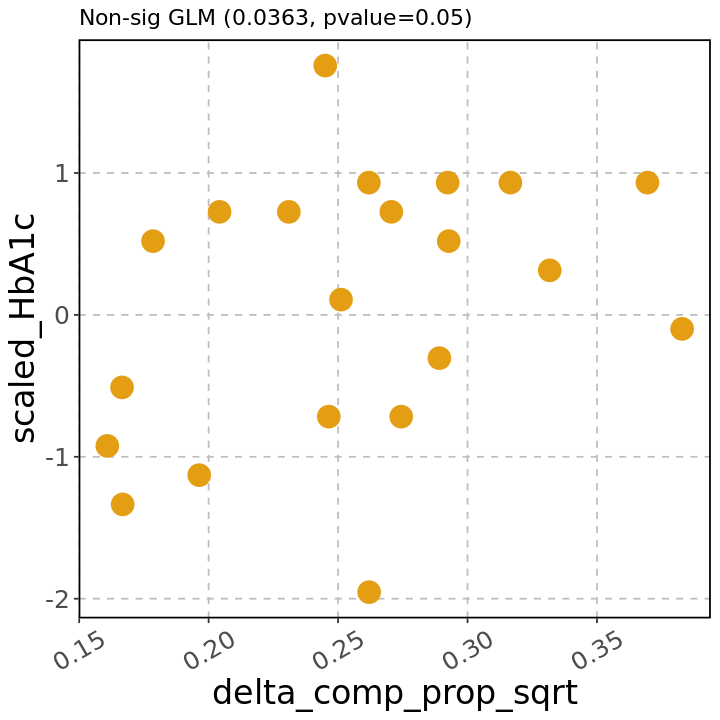

[1] "gamma_comp_prop_sqrt"
[1] "sex"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


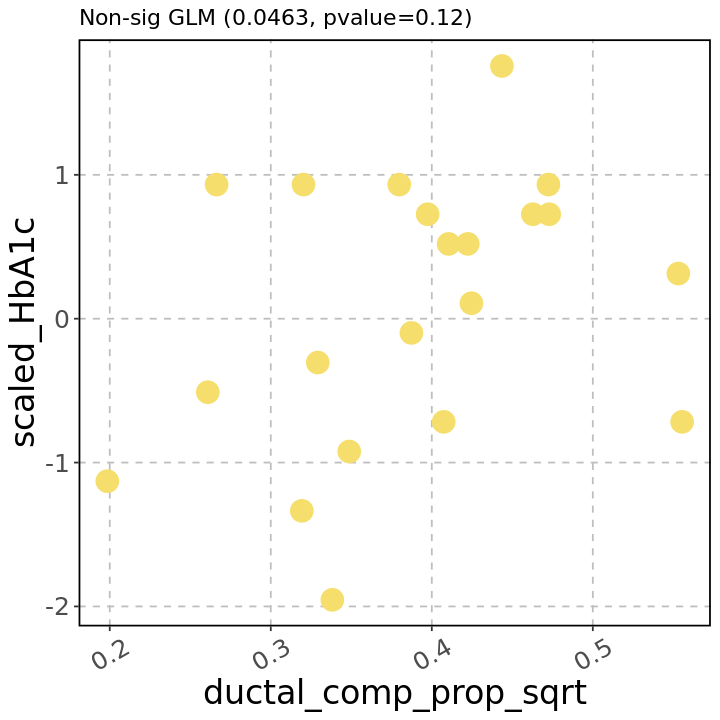

[1] "immune_comp_prop_sqrt"
[1] "sex"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


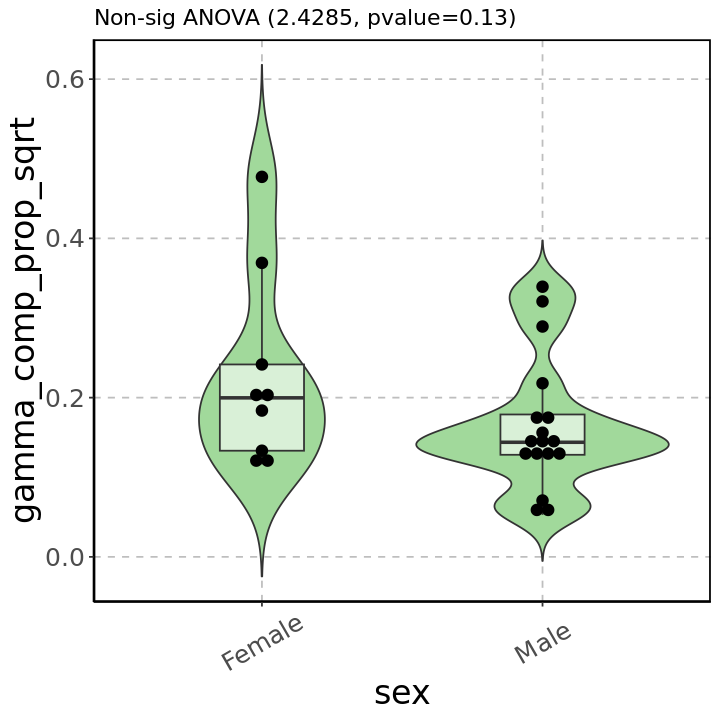

[1] "immune_comp_prop_sqrt"
[1] "collagenase_type"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


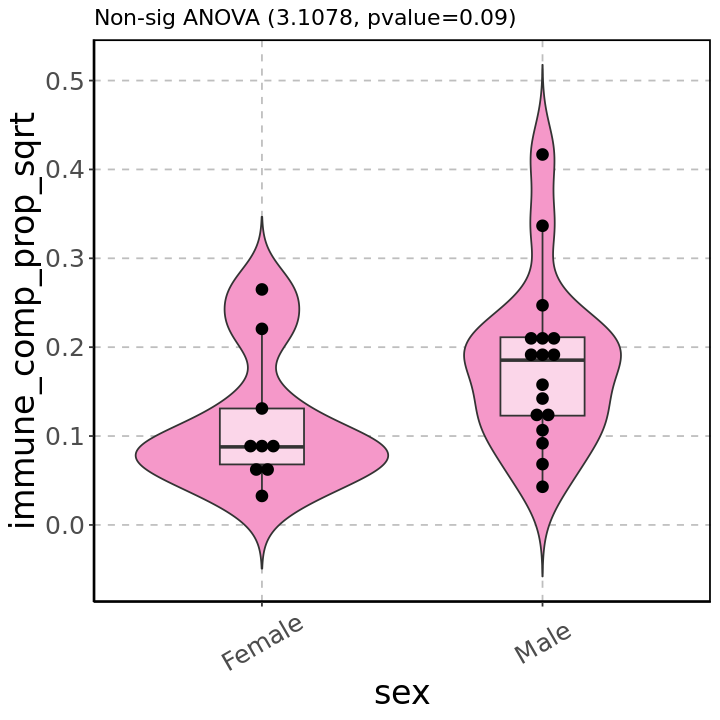

[1] "acinar_comp_prop_sqrt"
[1] "pancreas_consistency"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


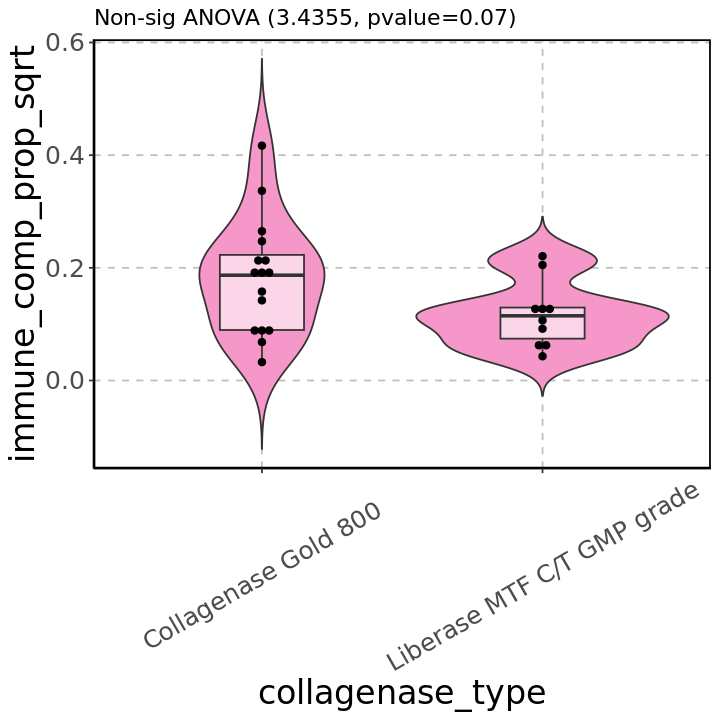

[1] "delta_comp_prop_sqrt"
[1] "pancreas_consistency"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


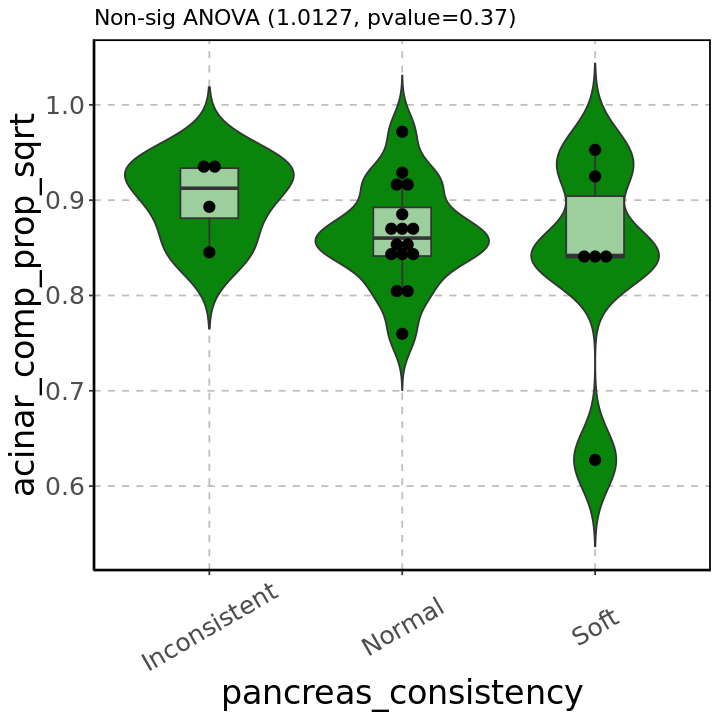

[1] "endothelial_comp_prop_sqrt"
[1] "pancreas_consistency"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


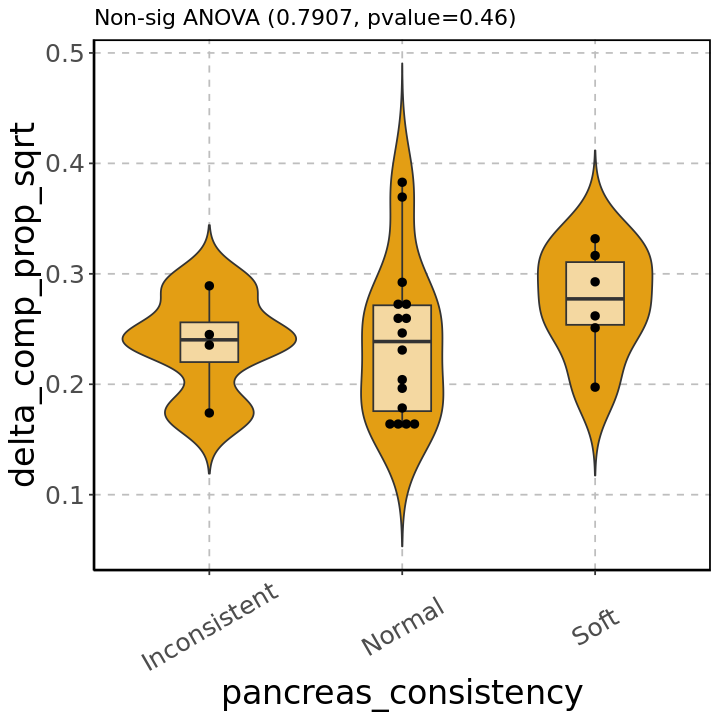

[1] "stellate_comp_prop_sqrt"
[1] "pancreas_consistency"


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.


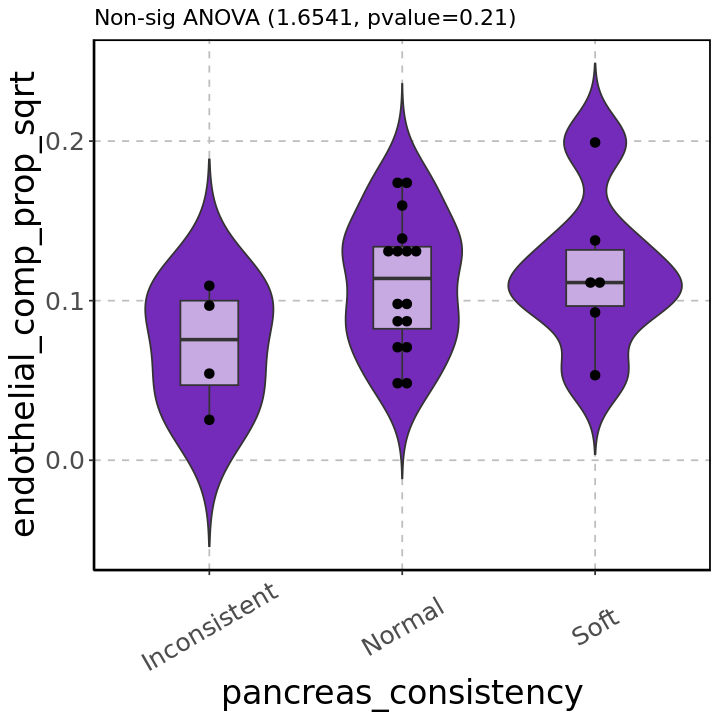

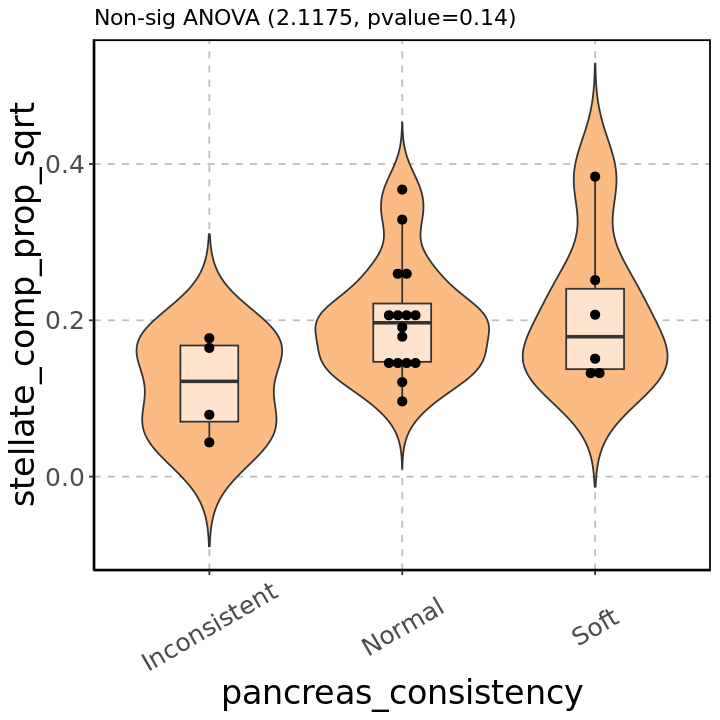

In [70]:
run_prefix <- 'scaled_counts'
comps1 <- c('alpha+scaled_age','gamma+scaled_BMI','delta+scaled_HbA1c','ductal+scaled_HbA1c')
comps2 <- c('gamma+sex','immune+sex','immune+collagenase_type','acinar+pancreas_consistency',
            'delta+pancreas_consistency','endothelial+pancreas_consistency','stellate+pancreas_consistency')

wrapper_plot_other_assocs('comp_prop_sqrt', comps1, comps2, meta)

# Adjust p-values and see if anything still passes significance

In [139]:
for(run_prefix in c('comp_prop_sqrt','total_prop_sqrt')){
    # Read in GLM results 
    res_fp <- file.path(outdir, sprintf('metadata_%s.multivar_glm.txt', run_prefix))
    res_df <- read.table(res_fp, sep='\t')
    colnames(res_df) <- gsub(paste0('_',run_prefix,'_'),'\\.',colnames(res_df))
    
    qvalues <- list()
    for(celltype in celltypes){
        colname <- paste0(celltype,'.pvalue')
        pvals <- res_df[,colname]
        qvals <- p.adjust(pvals, method='BH')
        qvalues[[celltype]] <- qvals
    }
    
    qvalues_df <- as.data.frame(qvalues)
    row.names(qvalues_df) <- row.names(res_df)
    colnames(qvalues_df) <- paste0(colnames(qvalues_df),'.qvalue')

    #reorganize for output
    res <- cbind(res_df, qvalues_df)
    test <- res %>% tibble::rownames_to_column(var='trait') %>%
                    tidyr::pivot_longer(!trait)
    test <- cbind(test, str_split_fixed(test$name,pattern='\\.',n=2)) %>%
                rename(celltype='1',test='2') %>% select(-name)
    test <- test %>% tidyr::pivot_wider(names_from=test, values_from=value)
    
    #write to file
    out_fp <- file.path(outdir, sprintf('metadata_%s.multivar_glm.wQVALUES.txt', run_prefix))
    write.table(test,out_fp,sep='\t',row.names=FALSE, quote=FALSE)
    print(subset(test,qvalue<0.1))
}

# A tibble: 1 × 6
  trait         celltype   coef tvalue pvalue qvalue
  <chr>         <chr>     <dbl>  <dbl>  <dbl>  <dbl>
1 scaled_purity immune   0.0673   2.83 0.0142 0.0997
# A tibble: 11 × 6
   trait                  celltype        coef tvalue   pvalue   qvalue
   <chr>                  <chr>          <dbl>  <dbl>    <dbl>    <dbl>
 1 scaled_age             endothelial  0.00485   2.22 0.0450   0.0630  
 2 scaled_age             immune       0.0118    3.68 0.00275  0.0185  
 3 scaled_BMI             endothelial -0.00616  -2.45 0.0290   0.0507  
 4 scaled_culture_time    endothelial -0.00892  -3.22 0.00669  0.0156  
 5 scaled_culture_time    immune      -0.0136   -3.34 0.00529  0.0185  
 6 scaled_pancreas_weight endothelial  0.0129    5.43 0.000116 0.000812
 7 scaled_pancreas_weight immune       0.0109    3.13 0.00793  0.0185  
 8 scaled_purity          beta         0.104     3.36 0.00513  0.0359  
 9 scaled_purity          acinar      -0.171    -4.76 0.000374 0.00261 
10 scaled_pu

In [140]:
for(run_prefix in c('comp_prop_sqrt','total_prop_sqrt')){
    # read in Anova results
    res_fp <- file.path(outdir, sprintf('metadata_%s.anova_onesided.txt', run_prefix))
    res_df <- read.table(res_fp, sep='\t')
    
    qvalues <- list()
    for(celltype in celltypes){
        colname <- paste0(celltype,'.pvalue')
        pvals <- res_df[,colname]
        qvals <- p.adjust(pvals, method='BH')
        qvalues[[celltype]] <- qvals
    }
    
    qvalues_df <- as.data.frame(qvalues)
    row.names(qvalues_df) <- row.names(res_df)
    colnames(qvalues_df) <- paste0(colnames(qvalues_df),'.qvalue')

    #reorganize for output
    res <- cbind(res_df, qvalues_df)
    test <- res %>% tibble::rownames_to_column(var='trait') %>%
                    tidyr::pivot_longer(!trait)
    test <- cbind(test, str_split_fixed(test$name,pattern='\\.',n=2)) %>%
                rename(celltype='1',test='2') %>% select(-name)
    test <- test %>% tidyr::pivot_wider(names_from=test, values_from=value)
    
    #write to file
    out_fp <- file.path(outdir, sprintf('metadata_%s.anova_onesided.wQVALUES.txt', run_prefix))
    write.table(test,out_fp,sep='\t',row.names=FALSE, quote=FALSE)
    print(subset(test,qvalue<0.1))
}

# A tibble: 3 × 5
  trait            celltype     stat pvalue qvalue
  <chr>            <chr>       <dbl>  <dbl>  <dbl>
1 sex              endothelial  7.13 0.0134 0.0401
2 sex              stellate     4.91 0.0364 0.0546
3 collagenase_type stellate     5.08 0.0335 0.0546
# A tibble: 1 × 5
  trait            celltype  stat pvalue qvalue
  <chr>            <chr>    <dbl>  <dbl>  <dbl>
1 collagenase_type ductal    7.00 0.0142 0.0425


# Code Graveyard

## 2. Continuous covariates: `cor.test`

In [42]:
### Function to compare the correlation of two columns in meta
### Also plots the relationship bt the two variables + a fit line?
### Assumes trait metadata is col1, and col2 is cell prop

compare_two_features_cortest <- function(meta, col1, col2, test_alternative){
    # Cut down dataframe for corr and ggplot 
    df <- meta[!is.na(meta[,col1]),c(col1, col2)]
    colnames(df) <- c('val1', 'val2')
    test_results <- cor.test(x=df$val1, y=df$val2, alternative=test_alternative, method='pearson', exact=TRUE)
    return(test_results)    
}


### Wrapper function which will apply cor.test to all combinations of meta traits and cell prop traits
### Also takes an input var for which alterative hypothesis to use for the cor.test (t,g,l)
cortest_wrapper <- function(meta, trait_list, ct_prop_list, test_alternative, prefix, outdir){
    # Create results df with filler columns (to set the row length)
    results <- data.frame(filler1=rep(0, length(trait_list)), filler2=rep(1, length(trait_list)))
     
    for (ct_prop in ct_prop_list){
        ct <- unlist(str_split(ct_prop, '_'))[1]
        ct_corr <- c()
        ct_pvalue <- c()
        for (trait in trait_list){
            test_results <- compare_two_features_cortest(meta, trait, ct_prop, test_alternative)
            ct_corr <- c(ct_corr, test_results$estimate)
            ct_pvalue <- c(ct_pvalue, test_results$p.value)
        }
        results <- cbind(results, data.frame(ct_corr, ct_pvalue))
    }
    # Finalize results formatting
    results <- results[,-c(1,2)]
    row.names(results) <- trait_list
    colnames(results) <- c(t(outer(ct_prop_list, c('cor', 'pvalue'), FUN = "paste", sep='_')))
    
    # Write results to a file and also return it for printouts
    fp <- file.path(outdir, sprintf('metadata_%s.cortest_%s.txt', prefix, test_alternative))
    write.table(results, fp, sep='\t', quote=FALSE)
    return(results)
}

### Run correlations -- greater and less separately and pick sig star based on cor direction

In [43]:
# prep list of cell type prop values to test
ct_props <- paste(celltypes, 'scaled_counts', sep='_')
ct_props
table(ct_props %in% colnames(meta_fin))

[1] "beta_scaled_counts"        "alpha_scaled_counts"      
[3] "delta_scaled_counts"       "gamma_scaled_counts"      
[5] "acinar_scaled_counts"      "ductal_scaled_counts"     
[7] "endothelial_scaled_counts" "immune_scaled_counts"     
[9] "stellate_scaled_counts"


TRUE 
   9 

In [46]:
# prep list of continuous metadata vars to test
cont_vars <- c('scaled_age','scaled_BMI','scaled_HbA1c','scaled_culture_time',
               'scaled_cold_ischemia_time','scaled_pancreas_weight','scaled_purity')

In [47]:
res1 <- cortest_wrapper(meta_fin, cont_vars, ct_props, 'greater', 'scaled_counts', outdir)
res2 <- cortest_wrapper(meta_fin, cont_vars, ct_props, 'less', 'scaled_counts', outdir)

In [48]:
# #test calculating qvalues per cell type prop

# for (celltype in celltypes){
#     print(celltype)
#     q <- p.adjust(res1[,paste0(celltype,'_scaled_counts_pvalue')], method='BH')
#     print(table(q < 0.1))
# }


## Plot cor.test results

In [53]:
sig_cutoff <- 0.05

In [64]:
#use both sets of results and choose more sig pvalue
cors <- res1[,grepl('cor', colnames(res1))]
p_greater <- res1[,grepl('pvalue', colnames(res1))]
p_less <- res2[,grepl('pvalue', colnames(res2))]

p_best <- list()
for (celltype in celltypes){
    colname <- paste0(celltype,'_scaled_counts_pvalue')
    p_best[[celltype]] <- pmin(p_greater[,colname],p_less[,colname])
}
p_best_df <- as.data.frame(p_best)
colnames(p_best_df) <- paste0(colnames(p_best_df),'_pvalue')
res_fin <- cbind(cors, p_best_df)

In [65]:
#format for plotting
cor_colnames <- colnames(res_fin)[grepl('cor',colnames(res_fin))]
pvalue_colnames <- colnames(res_fin)[grepl('pvalue',colnames(res_fin))]
data <- cbind(reshape2::melt(as.matrix(res_fin[,cor_colnames])), reshape2::melt(res[,pvalue_colnames])$value)
colnames(data) <- c('feature', 'ct_prop', 'cor', 'pvalue')

# Add in additional information needed for plotting
data$celltype <- str_split_fixed(data$ct_prop, '_', 3)[,1]
data$color <- major_colors[data$celltype]
data$sig_pos <- ifelse(data$pvalue <= sig_cutoff & data$cor > 0, '*', '')
data$sig_neg <- ifelse(data$pvalue <= sig_cutoff & data$cor < 0, '*', '')
head(data)

No id variables; using all as measure variables



feature                   ct_prop                cor          pvalue    
1 scaled_age                beta_scaled_counts_cor  0.009438815 0.48098989
2 scaled_BMI                beta_scaled_counts_cor -0.195656499 0.15918783
3 scaled_HbA1c              beta_scaled_counts_cor -0.151776913 0.24468035
4 scaled_culture_time       beta_scaled_counts_cor  0.293533169 0.06475486
5 scaled_cold_ischemia_time beta_scaled_counts_cor -0.313060956 0.05238993
6 scaled_pancreas_weight    beta_scaled_counts_cor  0.271901320 0.08080107
  celltype color   sig_pos sig_neg
1 beta     #3F98E0                
2 beta     #3F98E0                
3 beta     #3F98E0                
4 beta     #3F98E0                
5 beta     #3F98E0                
6 beta     #3F98E0

## Investigate weird purity associations with scaled counts

In [185]:
head(meta_fin)

age scaled_age BMI  scaled_BMI HbA1c scaled_HbA1c sex    culture_time
R207 50  -0.3176239 22.2 -1.5961071  NA           NA   Female  70         
R217 71   1.1885281 35.5  1.5372102 6.3    1.7566453   Female  15         
R218 73   1.3319711 28.4 -0.1354630 5.9    0.9320975   Female  70         
R221 44  -0.7479530 30.5  0.3592713 5.3   -0.3047242   Male   136         
R223 54  -0.0307378 27.0 -0.4652858 5.8    0.7259606   Male    64         
R226 30  -1.7520544 32.3  0.7833293 4.9   -1.1292720   Female  16         
     scaled_culture_time cold_ischemia_time ⋯ collagenase_type          
R207  0.7433497          16.60              ⋯ Liberase MTF C/T GMP grade
R217 -0.9339522          35.00              ⋯ Liberase MTF C/T GMP grade
R218  0.7433497          17.00              ⋯ Liberase MTF C/T GMP grade
R221  2.7561120           6.25              ⋯ Liberase MTF C/T GMP grade
R223  0.5603713          14.00              ⋯ Liberase MTF C/T GMP grade
R226 -0.9034558          18.60              ⋯ Collagenase Gold 800      
     beta_scaled_counts alpha_scaled_counts delta_scaled_counts
R207 -7.733599          -7.651133           -7.695655          
R217 -7.799422          -7.688162           -7.715787          
R218 -7.587793          -7.522656           -7.527676          
R221 -7.606234          -7.625395           -7.609457          
R223 -7.793955          -7.690319           -7.687380          
R226 -7.887544          -7.780197           -7.855236          
     gamma_scaled_counts acinar_scaled_counts ductal_scaled_counts
R207 -7.595715           -7.448519            -7.575775           
R217 -7.705090           -7.610753            -7.632750           
R218 -7.341546           -7.283688            -7.352281           
R221 -7.473350           -7.345806            -7.502210           
R223 -7.646098           -7.438699            -7.585146           
R226 -7.779442           -7.507496            -7.720138           
     endothelial_scaled_counts immune_scaled_counts stellate_scaled_counts
R207 -7.358224                 -7.275294            -7.383786             
R217 -7.559138                 -7.447502            -7.555983             
R218 -7.435219                 -7.112008            -7.482188             
R221 -7.437401                 -7.479703            -7.386801             
R223 -7.464328                 -7.502954            -7.583763             
R226 -7.351571                 -7.770643            -7.573149

In [207]:
cols <- paste0(celltypes,'_scaled_counts')
data <- meta_fin %>% select(purity, all_of(cols)) %>% 
        arrange(purity) %>%
        tibble::rownames_to_column(var='library')

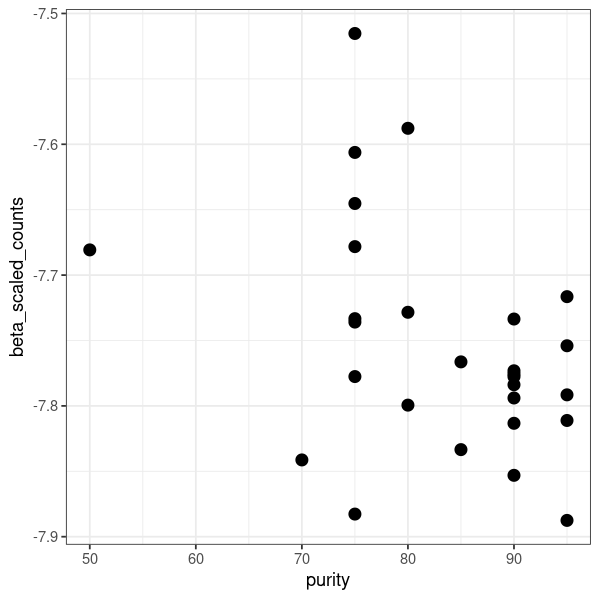

In [208]:
options(repr.plot.height=5, repr.plot.width=5)
ggplot(data, aes(x=purity, y=beta_scaled_counts)) +
        geom_point(size=3)

In [209]:
#calc raw prop beta cells to compare (bt all cell types)
num_cells <- as.data.frame(table(adata$library,adata$major_celltypes_fin))
num_cells <- num_cells %>% rename(library=Var1, celltype=Var2, cells=Freq) %>%
                tidyr::pivot_wider(names_from=celltype, values_from=cells) %>%
                group_by(library) %>%
                mutate(total_cells=sum(acinar,alpha,beta,delta,ductal,endothelial,gamma,immune,stellate))
head(num_cells)

library acinar alpha beta delta ductal endothelial gamma immune stellate
1 R207     580   2025  3229 217    45    8            99   33     12      
2 R217    2489    348  1431 150   614    2           569   10      6      
3 R218     165    227  1496 133    52    2            83    4     10      
4 R221    2389    905  1057 183   294    8            44    5     17      
5 R223     711   1616  3453 225   203    7           101    8     19      
6 R226     815   1492  3242 193    34    2            79    4      8      
  total_cells
1 6248       
2 5619       
3 2172       
4 4902       
5 6343       
6 5869

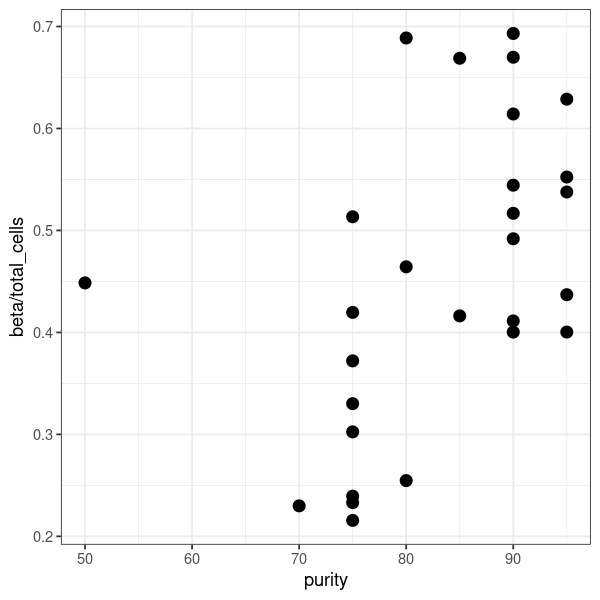

In [210]:
options(repr.plot.height=5, repr.plot.width=5)
data2 <- left_join(data, num_cells, by='library')

ggplot(data2, aes(x=purity, y=beta/total_cells)) +
        geom_point(size=3)

In [239]:
#pull min and max beta cell proportion numbers for paper results
#LOL move this to figure making section so it doesn't get lost
prop_beta <- num_cells$beta/num_cells$total_cells
sort(prop_beta)

[1] 0.2156263 0.2298936 0.2330395 0.2393949 0.2546716 0.3024494 0.3301274
 [8] 0.3720814 0.4002996 0.4003364 0.4112363 0.4162002 0.4196380 0.4369667
[15] 0.4485677 0.4643416 0.4918351 0.5134111 0.5168054 0.5377093 0.5443796
[22] 0.5523939 0.6142305 0.6287390 0.6688803 0.6698725 0.6887661 0.6931781